In [4]:
import numpy as np
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import random

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DOWNLOAD_MNIST = True # If already download , set as False
train_data = torchvision.datasets.MNIST(root="./mnist/", train=True, download=DOWNLOAD_MNIST)
test_data = torchvision.datasets.MNIST(root="./mnist/", train=False)


X_train = train_data.train_data.numpy()
X_test = test_data.test_data.numpy()

Y_train = train_data.train_labels.numpy()
Y_test = test_data.test_labels.numpy()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# Problem 1 Data Processing

## (a)

5


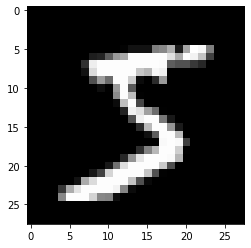

In [4]:
plt.imshow(X_train[0], cmap="gray")
print(Y_train[0])

First sample is shown in graph with number 5, and the corresponding y-value is also 5.

## (b) Data shape and normalizing

In [5]:
print("The dimension of X_train is", X_train.shape)
print("The dimension of X_test is", X_test.shape)
X_train_reshape = X_train.reshape(60000,-1)
X_test_reshape = X_test.reshape(10000,-1)
#xmax_test, xmin_test = X_test.max(), X_test.min()
#X_test_norm = (X_test - xmin_test)/(xmax_test - xmin_test)

The dimension of X_train is (60000, 28, 28)
The dimension of X_test is (10000, 28, 28)


In [6]:
from sklearn import preprocessing
X_train_norm = preprocessing.normalize(X_train_reshape)
X_test_norm = preprocessing.normalize(X_test_reshape)

## (c) One hot encoding

In [7]:
from tensorflow.keras.utils import to_categorical
y_train_encoding = to_categorical(Y_train)
y_test_encoding = to_categorical(Y_test)

We noticed that Y take values of integers, but we are dealing with a classification problem. Therefore, One-hot-encoding allows us to change numerical values to categorical values for computers to learn. 
It prevents the possibilities that computer treat Y as integer values. It also prevents effects generated by higher integers. For example, the class that are labeled with 6 does not has more weight than class labeled with 1.

# Problem 2

## (a)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_norm,y_train_encoding)
knn_predict = knn.predict(X_test_norm).argmax(axis=1)

Test error for KNN:

In [ ]:
sum(knn_predict != Y_test)/len(knn_predict)

0.0273

The test error for KNN is 2.73% which is smaller than the test error stated in the problem. In this part, I didn't change any parameters in the KNN function in sklearn. The default n_neighbors is 5. 
Justification: Since we have test error of 2.73%, we cannot reproduce the results by using default parameters. Possible reasons are that they didn't use K=5, or other important parameters such as weight. Also, I noticed that there are many parameters including algorithms, metric, and using different values of them will also produce different test error.

### AdaBoost.M1

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
Ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15),random_state=1)
Ada.fit(X_train_norm,Y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15),
                   random_state=1)

In [ ]:
Ada_predict = Ada.predict(X_test_norm)

Test error for AdaBoost:

In [ ]:
sum(Ada_predict != Y_test)/10000

0.0392

From our result, the test error for Adaboost is 3.92% which is close to 4.05%. Therefore, we "kind-of" reproduce the result. 
Justification: AdaBoost takes a long time to train with large "max-depth" parameter. But we found that larger "max_depth" actually produce better results in the grid search. The difference between our AdaBoost model and model in the paper is that the base estimator of our model is actually CART in sklearn. CART is similar with C4.5 but CART construct the tree by numerical splitting critirion. Therefore, by using our model, we cannot reproduce the exact test error stated in the project.
Also, since we don't know the exact parameters they use, even though we use the grid search to produce the similar result, the parameters we use might not be the same in their experiements.

### SVM with Gaussian Kernel

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel="rbf")
svm.fit(X_train_norm, Y_train)

SVC()

In [ ]:
svm_predict = svm.predict(X_test_norm)

Test error for SVM:

In [ ]:
sum(svm_predict != Y_test)/10000

0.0189

The test error for SVM is 1.89% which is similar to the reported test error. In the model we use, we didn't tune any parameters, and it is constructed with default parameters. 
Justification: from the lecture, we know that kernel is a very important parameter in SVM. Therefore, since the report has speficified the kernel they used, we might reproduce the result that is similar with reported test error.

## (b)

In [ ]:
import keras
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers



X_train_new = X_train.astype("float32") / 255
X_test_new = X_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
X_train_new = np.expand_dims(X_train_new, -1)
X_test_new = np.expand_dims(X_test_new, -1)

model1 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding="same", activation = "relu", input_shape = (28, 28, 1)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), padding="same", activation = "relu"),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), padding="same", activation = "relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dense(10)
])

model1.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = "adam", metrics = ["accuracy"])

history = model1.fit(X_train_new, Y_train, epochs = 10,
                    validation_data=(X_test, Y_test))

In [ ]:
score = model1.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test error", 1-score[1])

Test loss: 0.02747156284749508
Test accuracy: 0.9922000169754028
Test error 0.007799983024597168


Since AdaBoost takes a long time to fit, we tried CNN for graph classification, which can be fast forward by using GPU. The test error for this model is 0.96%, and it is greater than all three models in the previous part.

# Problem 3

## (a) One-Layer ANN

In [8]:
# Reshape into (,784) for input

x_train = X_train.reshape(60000, 784)
x_test = X_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Flatten, MaxPooling2D, Activation, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense


60000 train samples
10000 test samples


In this part, we will first construct an artificial neural network by using one layer with 100 hidden layers. We first dense it to 100 units, and dense it to 10 units for output since we have 10 classes.
Labels are processed by one-hot encoding for the reason listed in previous part.

In [ ]:
# Define a function that returns the results as an dataframe for convenience after

def nn(x, epoch=300, batch=256, lr=0.1, mmt=0):

  # x: random seed
  # epoch: number of epoch in each model
  # batch: batch size in each model
  # lr: learning rate in SGD for each model
  # mmt: momentum in SGD for each model

  # Set seed for reproducing the results and for different weights
  tf.random.set_seed(x)
  
  # Define a model that only one layer with 100 hidden units
  nn = Sequential([keras.layers.Dense(100),
                   keras.layers.Dense(10, activation="softmax")
                   ])
  
  # Loss is crossentrypy and optimizer is SGD
  nn.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=mmt),
             metrics=['accuracy'])
  
  # Save the results and make it into dataframe for plotting convenience
  history = nn.fit(x_train, y_train_encoding, epochs=epoch, batch_size=256, validation_data=(x_test, y_test_encoding),verbose=0)
  df = pd.DataFrame(history.history)
  return df

In [ ]:
#train_loss = pd.DataFrame()
#val_loss = pd.DataFrame()
#train_error = pd.DataFrame()
#val_error = pd.DataFrame()

In [ ]:
#for i in range(5):
  #temp = nn(i)
  #train_loss["time"+str(i)] = temp.loss
  #val_loss["time"+str(i)] = temp.val_loss
  #train_error["time"+str(i)] = 1-temp.accuracy.values
  #val_error["time"+str(i)] = 1-temp.val_accuracy.values

It takes long to train 5 times with at least 150 epoch, so we save all the results into dataframe so that we can save it as an .csv file for future reuse.
The code are annotated so that it won't execute again.

In [31]:
#ann_results = pd.concat([train_loss.add_prefix("trloss_"),val_loss.add_prefix("valloss_"),train_error.add_prefix("trerror_"),val_error.add_prefix("valerror_")],axis=1)
#ann_results.to_csv("ann_results.csv")
ann_results = pd.read_csv("output/ann_results1.csv",index_col=0)
ann_results.head(2)

,trloss_time0,trloss_time1,trloss_time2,trloss_time3,trloss_time4,valloss_time0,valloss_time1,valloss_time2,valloss_time3,valloss_time4,...,lr02_val_loss,lr02_val_accuracy,mmt05_loss,mmt05_accuracy,mmt05_val_loss,mmt05_val_accuracy,mmt09_loss,mmt09_accuracy,mmt09_val_loss,mmt09_val_accuracy
0,0.530906,0.541693,0.542349,0.548711,0.539338,0.351215,0.349527,0.357278,0.352773,0.349500,...,0.334198,0.9039,0.447502,0.873467,0.318729,0.9095,0.403197,0.882250,0.342116,0.8991
1,0.342998,0.341764,0.341605,0.343791,0.342699,0.315696,0.310577,0.311592,0.314470,0.315361,...,0.312507,0.9097,0.316618,0.910250,0.299610,0.9148,0.313899,0.911267,0.297570,0.9155


We read files results directly from the .csv file that we previously saved. The code for saving file has been annotated.

## (a) Cross-entropy error vs. Epoch

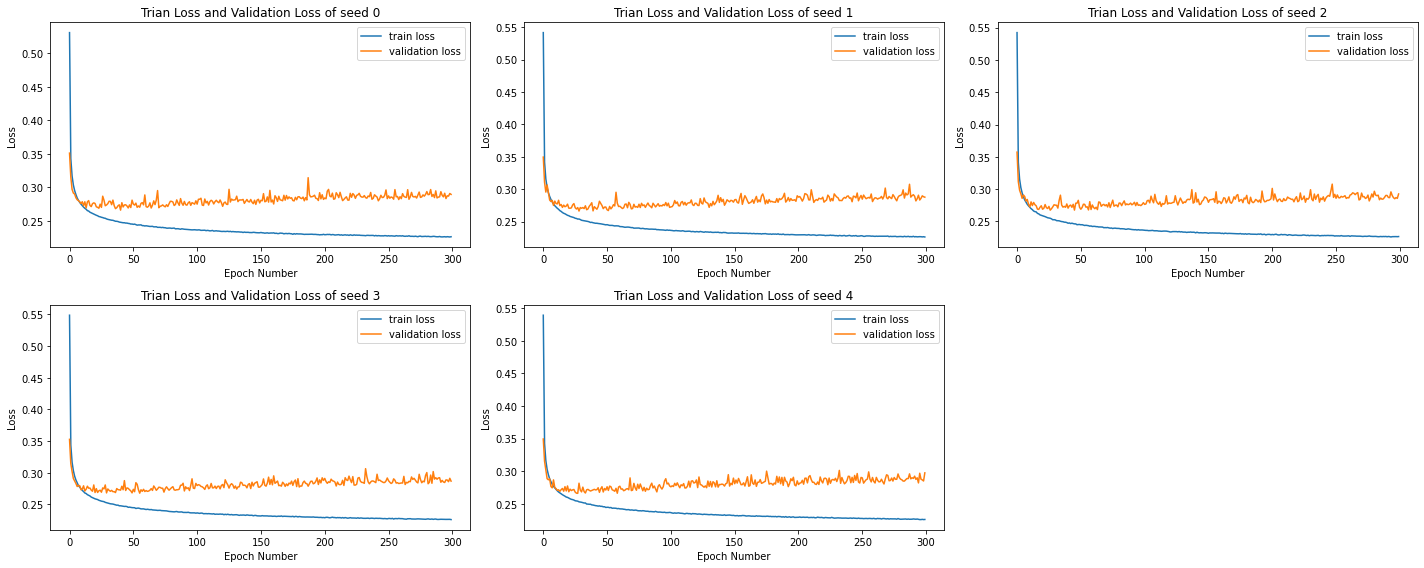

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(20,8))
for i in range(2):
  for j in range(3):
    if i==1 and j==2:
      break
    else:
      ax[i][j].plot(ann_results.loc[:, ann_results.columns.str.startswith("trloss_")].values[:,i*3+j], label="train loss")
      ax[i][j].plot(ann_results.loc[:, ann_results.columns.str.startswith("valloss_")].values[:,i*3+j], label="validation loss")
      ax[i][j].set_title("Trian Loss and Validation Loss of seed "+str(i*3+j))
      ax[i][j].set_xlabel("Epoch Number")
      ax[i][j].set_ylabel("Loss")
      ax[i][j].legend()
plt.tight_layout()
plt.delaxes(ax[1][2])
plt.legend()

## (b) Misclassification Rate vs. Epoch

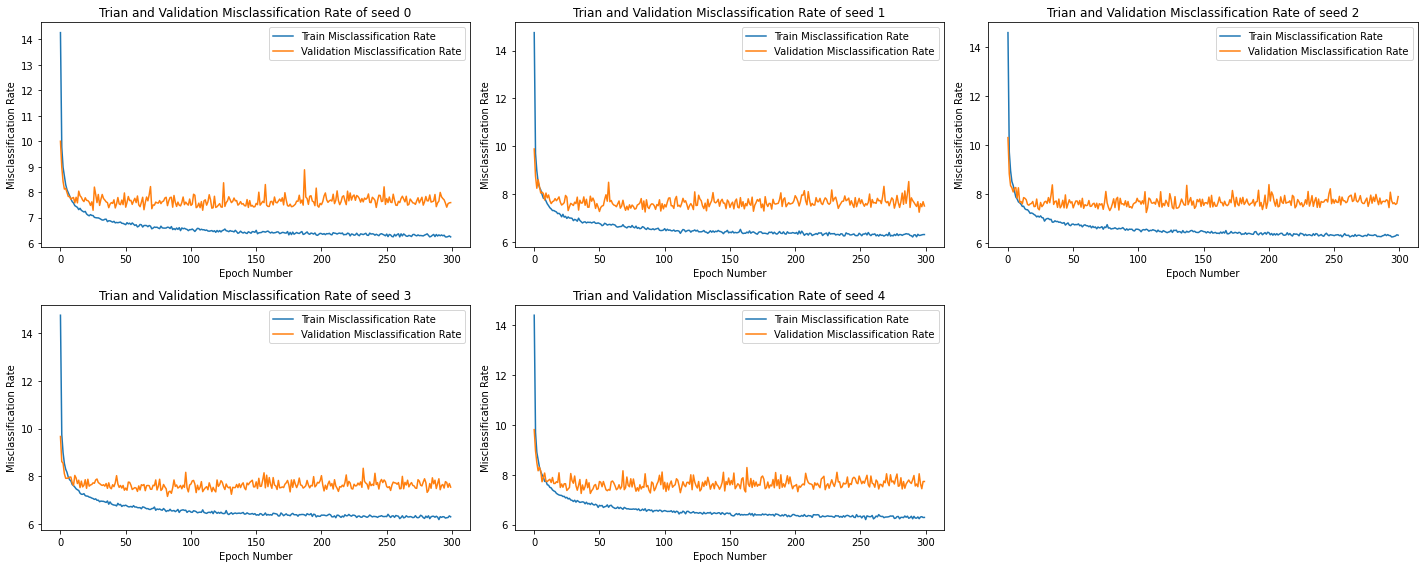

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(20,8))
for i in range(2):
  for j in range(3):
    if i==1 and j==2:
      break
    else:
      ax[i][j].plot(ann_results.loc[:, ann_results.columns.str.startswith("trerror_")].values[:,i*3+j]*100, label="Train Misclassification Rate")
      ax[i][j].plot(ann_results.loc[:, ann_results.columns.str.startswith("valerror_")].values[:,i*3+j]*100, label="Validation Misclassification Rate")
      ax[i][j].set_title("Trian and Validation Misclassification Rate of seed "+str(i*3+j))
      ax[i][j].set_xlabel("Epoch Number")
      ax[i][j].set_ylabel("Misclassification Rate")
      ax[i][j].legend()
plt.tight_layout()
plt.delaxes(ax[1][2])

## (c) Visualiziation of learned W
The critirion of best model for this part is the validation loss. We sum the validation loss for 300 epoch.

In [ ]:
ann_results.loc[:, ann_results.columns.str.startswith("valloss_")].sum(axis=0).sort_values()

valloss_time4    84.494100
valloss_time1    84.496837
valloss_time3    84.582569
valloss_time0    84.638598
valloss_time2    84.723417
dtype: float64

The summation will serve the same purpose as the mean. Therefore, we can just use the summation here. By the results, model 4 with seed(4) has the lowest reults. Therefore, the weights in model4 for layer 1 will be visualized.

Since we did not save the full model in previous part, we will pull in the model out and train it again to get the weights.

In [ ]:
# Reproduce the model with seed 4 to get the weights
tf.random.set_seed(4)
best_model = Sequential([keras.layers.Dense(100),
                   keras.layers.Dense(10, activation="softmax")
                   ])
best_model.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=0.1),
             metrics=['accuracy'])
best_history = best_model.fit(x_train, y_train_encoding, epochs=300, batch_size=256, validation_data=(x_test, y_test_encoding),verbose=0)

In [ ]:
best_model.evaluate(x_test,y_test_encoding)

313/313 [==============================] - 1s 3ms/step - loss: 0.2976 - accuracy: 0.9227


[0.29762476682662964, 0.9226999878883362]

In [ ]:
weights = best_model.layers[0].get_weights()[0]
weights.shape

(784, 100)

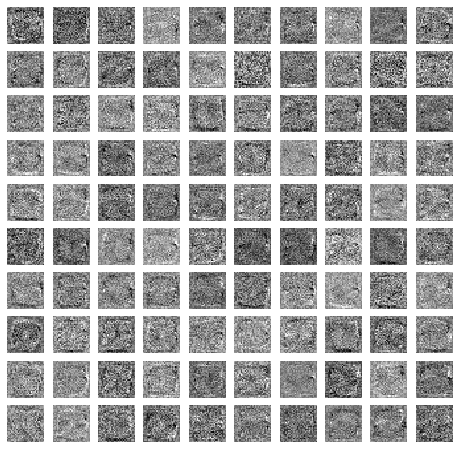

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(weights.shape[1]):
    plt.subplot(10, 10, i + 1) # Since we know it is a 10 x 10 grid
    x = weights[:,i]
    plt.imshow(x.reshape((28, 28)), cmap = "gray", interpolation = "nearest")
    plt.axis("off")

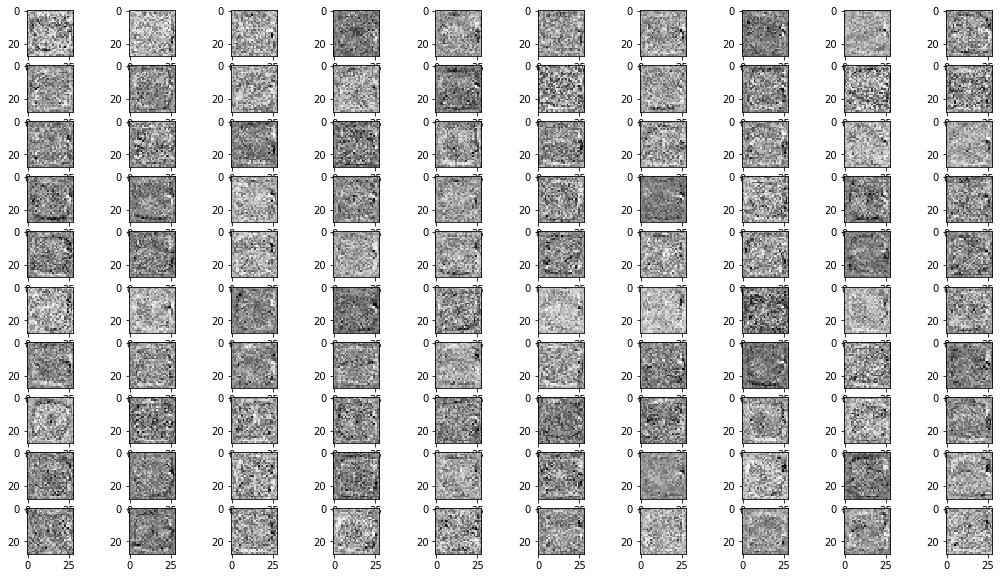

In [ ]:
fig,ax=plt.subplots(10,10, figsize=(18,10))
for i in range(10):
  for j in range(10):
    ax[i,j].imshow(weights[:,i*10+j].reshape(28,28),cmap="Greys",interpolation = "nearest")

## (d) Different parameters

In [ ]:
#lr001 = nn(0, epoch=150, batch=256, lr=0.01)
#lr02 = nn(0, epoch=150, batch=256, lr=0.2)
#mom05 = nn(0, epoch=150, mmt=0.5)
#mom09 = nn(0, epoch=150, mmt=0.9)

In [ ]:
#ann_lr_mmt = pd.concat([lr001.add_prefix("lr001_"),lr02.add_prefix("lr02_"), mom05.add_prefix("mmt05_"), mom09.add_prefix("mmt09_")],axis=1)
#ann_results_final = pd.concat([ann_results,ann_lr_mmt],axis=1)
#ann_results_final.to_csv("ann_results1.csv")
#pd.read_csv("drive/MyDrive/5241 Project/ann_results1.csv",index_col=0)
#ann_results.loc[:, ann_results.columns.str.startswith("lr"+pivots[i])].dropna()
#ann_results_final.loc[:, ann_results_final.columns.str.startswith("lr"+pivots[i])]

In [37]:
ann_results.loc[:, ann_results.columns.str.endswith("accuracy")] = (1-ann_results.loc[:, ann_results.columns.str.endswith("accuracy")])*100
ann_results.head(2)

,trloss_time0,trloss_time1,trloss_time2,trloss_time3,trloss_time4,valloss_time0,valloss_time1,valloss_time2,valloss_time3,valloss_time4,...,lr02_val_loss,lr02_val_accuracy,mmt05_loss,mmt05_accuracy,mmt05_val_loss,mmt05_val_accuracy,mmt09_loss,mmt09_accuracy,mmt09_val_loss,mmt09_val_accuracy
0,0.530906,0.541693,0.542349,0.548711,0.539338,0.351215,0.349527,0.357278,0.352773,0.349500,...,0.334198,9.609997,0.447502,12.653333,0.318729,9.050000,0.403197,11.774999,0.342116,10.089999
1,0.342998,0.341764,0.341605,0.343791,0.342699,0.315696,0.310577,0.311592,0.314470,0.315361,...,0.312507,9.030002,0.316618,8.974999,0.299610,8.520001,0.313899,8.873332,0.297570,8.450001


### Different learning rate:

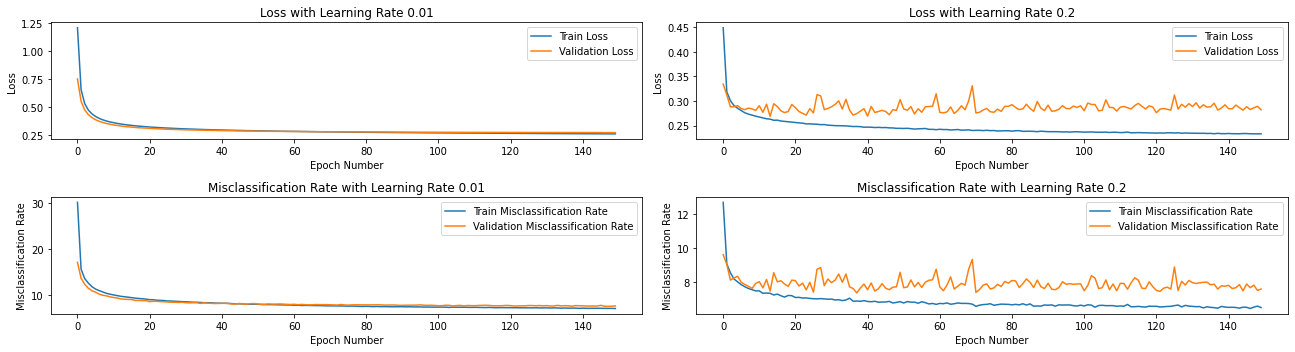

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(18,5))
pivots = ["001","02","05","09"]
rate = ["0.01","0.2","0.5","0.9"]
for i in range(2):
  for j in range(2):
    if j==0:
      kind="Loss"
    else:
      kind="Misclassification Rate"
    ax[j][i].plot(ann_results.loc[:, ann_results.columns.str.startswith("lr"+pivots[i])].dropna().iloc[:,j], label=str("Train "+kind))
    ax[j][i].plot(ann_results.loc[:, ann_results.columns.str.startswith("lr"+pivots[i])].dropna().iloc[:,j+2], label=str("Validation "+kind))
    ax[j][i].set_xlabel("Epoch Number")
    ax[j][i].set_ylabel(kind)
    ax[j][i].legend()
    ax[j][i].set_title(kind+" with "+"Learning Rate "+rate[i])
plt.tight_layout()
plt.legend()

### Different Momentum

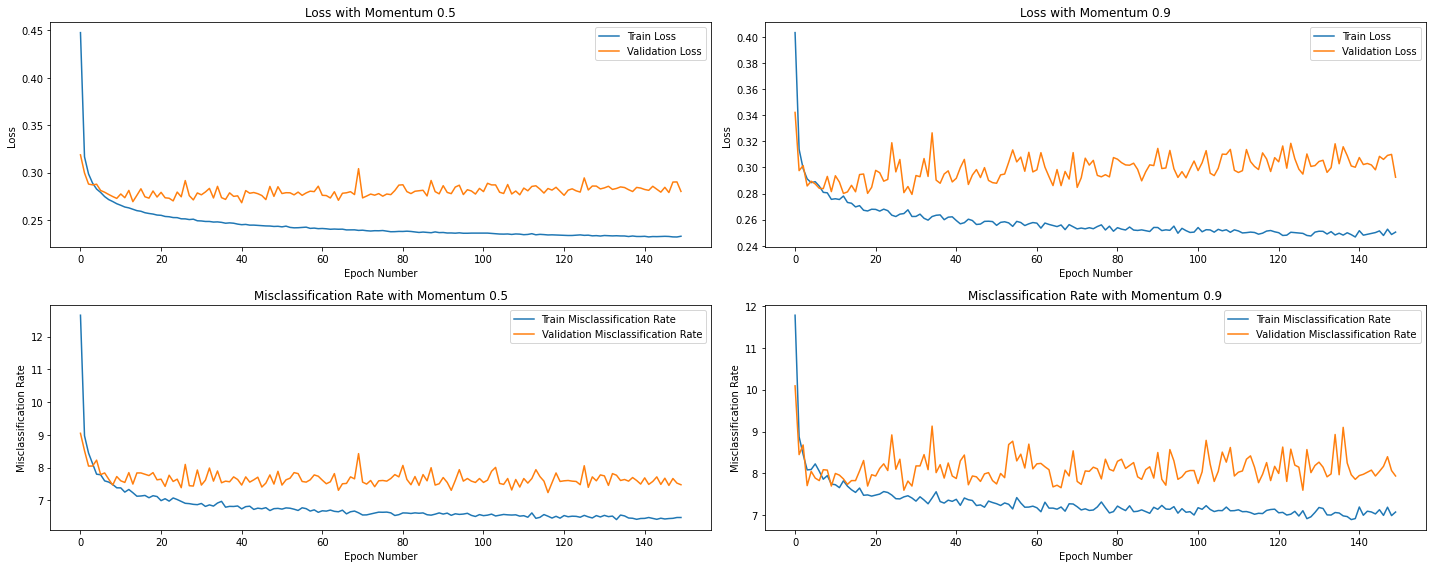

In [38]:
fig,ax = plt.subplots(2,2, figsize=(20,8))
pivots = ["001","02","05","09"]
rate = ["0.01","0.2","0.5","0.9"]
for i in range(2):
  for j in range(2):
    if j==0:
      kind="Loss"
    else:
      kind="Misclassification Rate"
    ax[j][i].plot(ann_results.loc[:, ann_results.columns.str.startswith("mmt"+pivots[i+2])].dropna().iloc[:,j], label=str("Train "+kind))
    ax[j][i].plot(ann_results.loc[:, ann_results.columns.str.startswith("mmt"+pivots[i+2])].dropna().iloc[:,j+2], label=str("Validation "+kind))
    ax[j][i].set_xlabel("Epoch Number")
    ax[j][i].set_ylabel(kind)
    ax[j][i].legend()
    ax[j][i].set_title(kind+" with "+"Momentum "+rate[i+2])
plt.tight_layout()
plt.legend()

# Problem 4

In [11]:
x_train = x_train.reshape(60000,28,28)
x_test = x_test.reshape(10000,28,28)
x_train.shape

(60000, 28, 28)

## One layer CNN

In [9]:
def cnn(x, epoch=150, batch=256, lr=0.1, mmt=0):
  tf.random.set_seed(x)
  
  cnn = Sequential([Conv2D(32, kernel_size=3, activation="relu", input_shape=(28,28,1)), 
                  MaxPooling2D(2,2), 
                  Flatten(), 
                  Dense(10, activation="softmax")]
                 )
  #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
  cnn.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=lr,momentum=mmt),
             metrics=['accuracy'])
  history = cnn.fit(x_train, y_train_encoding, epochs=epoch, batch_size=batch, validation_data=(x_test, y_test_encoding),verbose=0)
  
  df = pd.DataFrame(history.history)

  return cnn,df

In [ ]:
#cnn1_trloss=pd.DataFrame()
#cnn1_valloss=pd.DataFrame()
#cnn1_trerror=pd.DataFrame()
#cnn1_valerror=pd.DataFrame()

#for i in range(5):
  #temp = cnn(i)[1]
  #cnn1_trloss["time"+str(i)] = temp.loss
  #cnn1_valloss["time"+str(i)] = temp.val_loss
  #cnn1_trerror["time"+str(i)] = 1-temp.accuracy.values
  #cnn1_valerror["time"+str(i)] = 1-temp.val_accuracy.values

In [33]:
#cnn1_results = pd.concat([cnn1_trloss.add_prefix("trloss_"),cnn1_valloss.add_prefix("valloss_"),
           #cnn1_trerror.add_prefix("trerror_"),
           #cnn1_valerror.add_prefix("valerror_")],axis=1)
#cnn1_results.to_csv("cnn1_results.csv")
cnn1_results = pd.read_csv("output/cnn1_results1.csv", index_col=0)

## (a) Cross-entropy Rate vs. Epoch

In [ ]:
cnn1_results.head(2)

,trloss_time0,trloss_time1,trloss_time2,trloss_time3,trloss_time4,valloss_time0,valloss_time1,valloss_time2,valloss_time3,valloss_time4,...,lr02_val_loss,lr02_val_accuracy,mmt05_loss,mmt05_accuracy,mmt05_val_loss,mmt05_val_accuracy,mmt09_loss,mmt09_accuracy,mmt09_val_loss,mmt09_val_accuracy
0,0.549696,0.561111,0.539142,0.554906,0.553025,0.364336,0.335084,0.397659,0.340779,0.327957,...,0.280718,0.9170,0.446219,0.870267,0.288761,0.9151,0.299511,0.915867,0.097624,0.9706
1,0.313686,0.333910,0.325967,0.318204,0.307732,0.279279,0.280088,0.295944,0.278687,0.284596,...,0.186297,0.9433,0.246592,0.928467,0.204750,0.9383,0.084831,0.975400,0.069409,0.9786


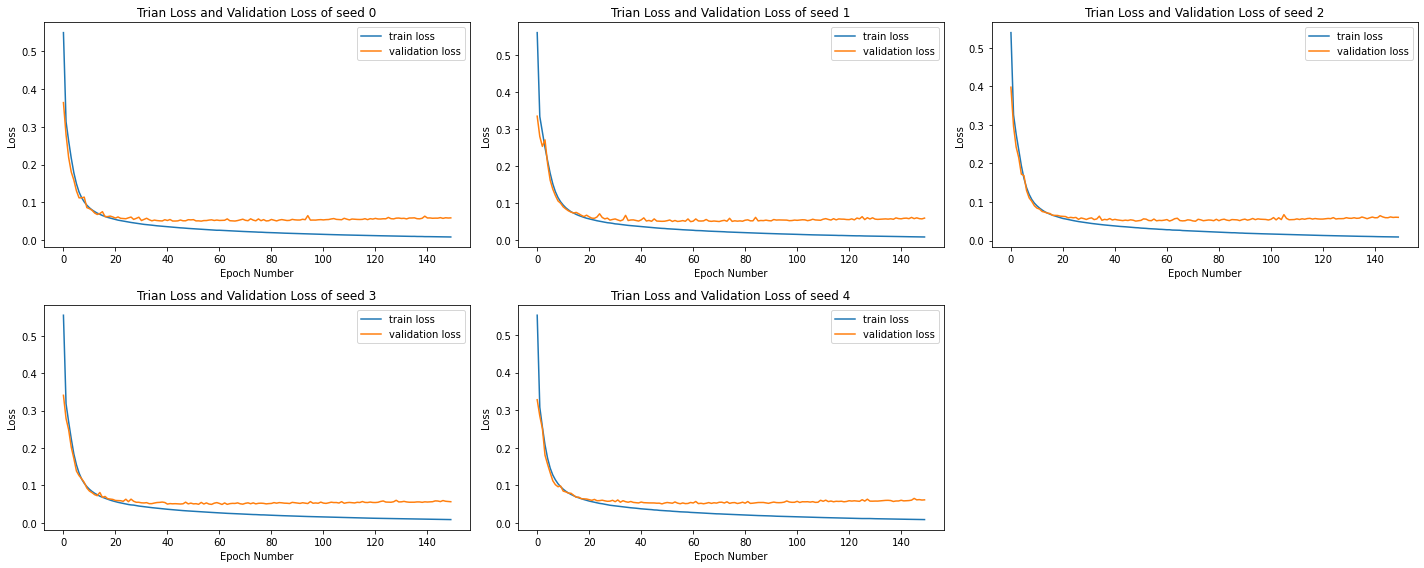

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(20,8))
for i in range(2):
  for j in range(3):
    if i==1 and j==2:
      break
    else:
      ax[i][j].plot(cnn1_results.loc[:, cnn1_results.columns.str.startswith("trloss_")].values[:,i*3+j], label="train loss")
      ax[i][j].plot(cnn1_results.loc[:, cnn1_results.columns.str.startswith("valloss_")].values[:,i*3+j], label="validation loss")
      ax[i][j].set_title("Trian Loss and Validation Loss of seed "+str(i*3+j))
      ax[i][j].set_xlabel("Epoch Number")
      ax[i][j].set_ylabel("Loss")
      ax[i][j].legend()
plt.tight_layout()
plt.delaxes(ax[1][2])
plt.legend()

## (b) Miss-classification Rate vs. Epoch

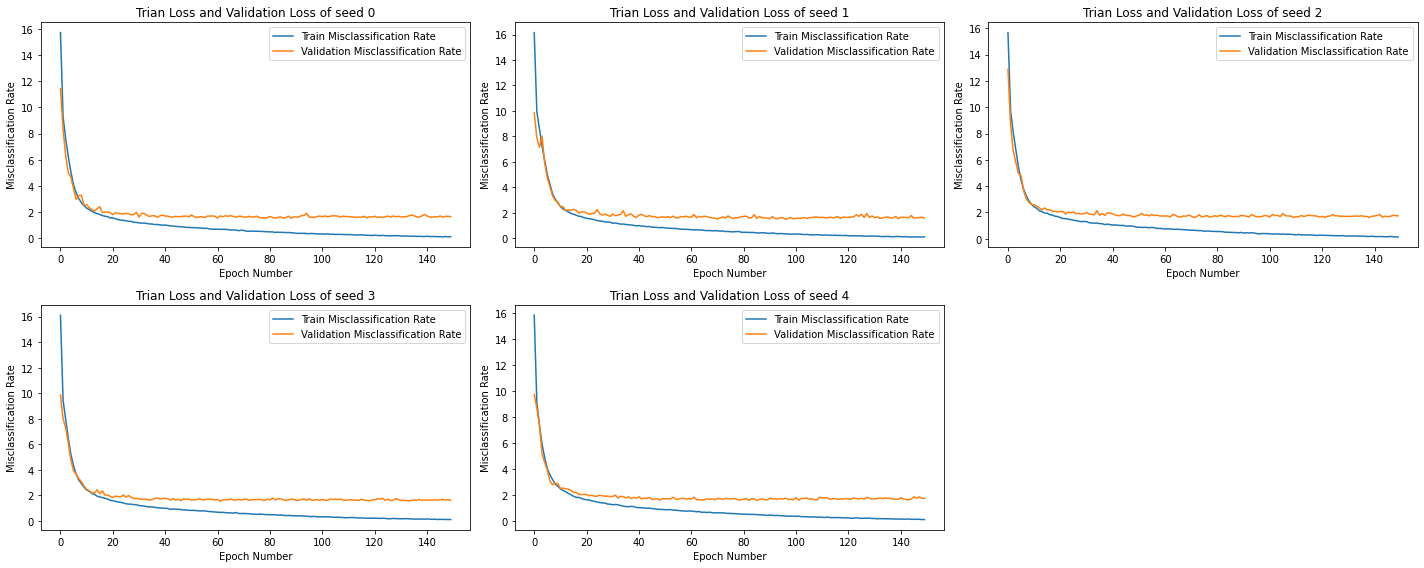

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(20,8))
for i in range(2):
  for j in range(3):
    if i==1 and j==2:
      break
    else:
      ax[i][j].plot(cnn1_results.loc[:, cnn1_results.columns.str.startswith("trerror_")].values[:,i*3+j]*100, label="Train Misclassification Rate")
      ax[i][j].plot(cnn1_results.loc[:, cnn1_results.columns.str.startswith("valerror_")].values[:,i*3+j]*100, label="Validation Misclassification Rate")
      ax[i][j].set_title("Trian Loss and Validation Loss of seed "+str(i*3+j))
      ax[i][j].set_xlabel("Epoch Number")
      ax[i][j].set_ylabel("Misclassification Rate")
      ax[i][j].legend()
plt.tight_layout()
plt.delaxes(ax[1][2])

## (c) Visualization of learned W

In [ ]:
cnn1_results.loc[:, cnn1_results.columns.str.startswith("valloss_")].sum(axis=0).sort_values()

valloss_time3    9.547331
valloss_time0    9.611428
valloss_time4    9.755195
valloss_time1    9.878571
valloss_time2    9.916452
dtype: float64

In [12]:
best_cnn1 = cnn(3)

In [13]:
best_cnn1[0].evaluate(x_test, y_test_encoding)

313/313 [==============================] - 2s 7ms/step - loss: 0.0562 - accuracy: 0.9838


[0.05624588578939438, 0.9837999939918518]

In [21]:
cnn1_weights = best_cnn1[0].layers[0].get_weights()[0][:,:,0,:]
cnn1_weights.shape

(3, 3, 32)

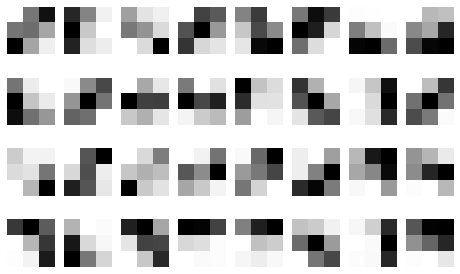

In [30]:
fig,ax=plt.subplots(4,8, figsize=(8,5))
for i in range(4):
  for j in range(8):
    ax[i,j].imshow(cnn1_weights[:,:,i*8+j],cmap="Greys")
    ax[i,j].axis('off')

## (d) Different Parameters

### Different Learing Rate

In [ ]:
#cnn1_lr_001 = cnn(0, lr=0.01)
#cnn1_lr_02 = cnn(0,lr=0.2)

#cnn1_mmt_05 = cnn(0, mmt=0.5)
#cnn1_mmt_09 = cnn(0, mmt=0.9)

In [ ]:
#cnn1_lr_mmt = pd.concat([cnn1_lr_001[1].add_prefix("lr001_"),cnn1_lr_02[1].add_prefix("lr02_"), cnn1_mmt_05[1].add_prefix("mmt05_"), cnn1_mmt_09[1].add_prefix("mmt09_")],axis=1)
#cnn1_final = pd.concat([cnn1_results, cnn1_lr_mmt],axis=1)
#cnn1_final.to_csv("cnn1_results1.csv")
cnn1_results = pd.read_csv("output/cnn1_results1.csv", index_col=0)

In [35]:
cnn1_results.loc[:, cnn1_results.columns.str.endswith("accuracy")] = (1-cnn1_results.loc[:, cnn1_results.columns.str.endswith("accuracy")])*100
cnn1_results.head(2)

,trloss_time0,trloss_time1,trloss_time2,trloss_time3,trloss_time4,valloss_time0,valloss_time1,valloss_time2,valloss_time3,valloss_time4,...,lr02_val_loss,lr02_val_accuracy,mmt05_loss,mmt05_accuracy,mmt05_val_loss,mmt05_val_accuracy,mmt09_loss,mmt09_accuracy,mmt09_val_loss,mmt09_val_accuracy
0,0.549696,0.561111,0.539142,0.554906,0.553025,0.364336,0.335084,0.397659,0.340779,0.327957,...,0.280718,8.300000,0.446219,12.973332,0.288761,8.490002,0.299511,8.413333,0.097624,2.939999
1,0.313686,0.333910,0.325967,0.318204,0.307732,0.279279,0.280088,0.295944,0.278687,0.284596,...,0.186297,5.669999,0.246592,7.153332,0.204750,6.169999,0.084831,2.460003,0.069409,2.139997


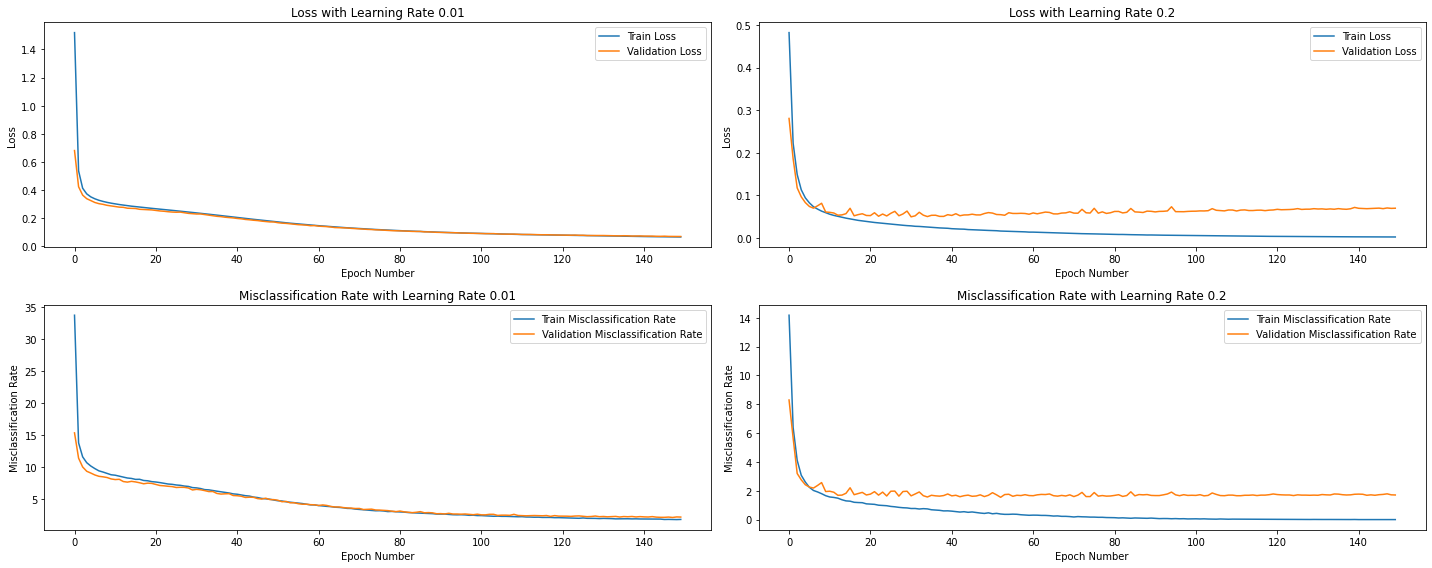

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(20,8))
pivots = ["001","02","05","09"]
rate = ["0.01","0.2","0.5","0.9"]
for i in range(2):
  for j in range(2):
    if j==0:
      kind="Loss"
    else:
      kind="Misclassification Rate"
    ax[j][i].plot(cnn1_results.loc[:, cnn1_results.columns.str.startswith("lr"+pivots[i])].iloc[:,j], label=str("Train "+kind))
    ax[j][i].plot(cnn1_results.loc[:, cnn1_results.columns.str.startswith("lr"+pivots[i])].iloc[:,j+2], label=str("Validation "+kind))
    ax[j][i].set_xlabel("Epoch Number")
    ax[j][i].set_ylabel(kind)
    ax[j][i].legend()
    ax[j][i].set_title(kind+" with "+"Learning Rate "+rate[i])
plt.tight_layout()
plt.legend()

### Different Momentum

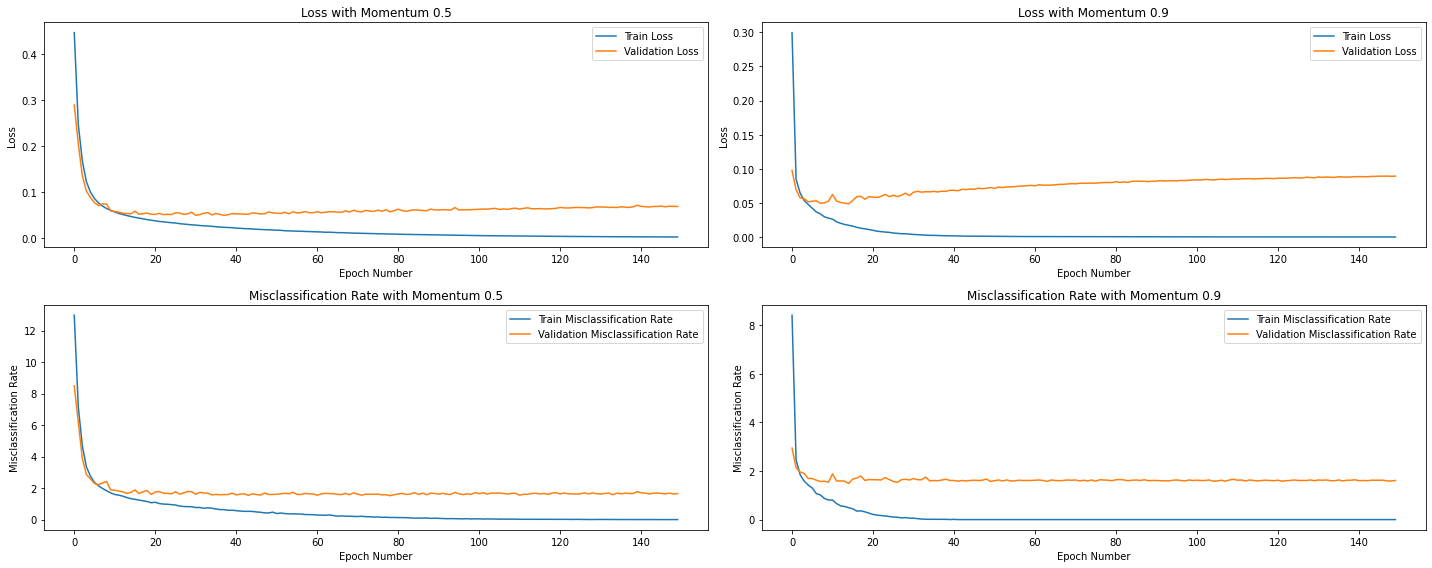

In [36]:
fig,ax = plt.subplots(2,2, figsize=(20,8))
pivots = ["001","02","05","09"]
rate = ["0.01","0.2","0.5","0.9"]
for i in range(2):
  for j in range(2):
    if j==0:
      kind="Loss"
    else:
      kind="Misclassification Rate"
    ax[j][i].plot(cnn1_results.loc[:, cnn1_results.columns.str.startswith("mmt"+pivots[i+2])].dropna().iloc[:,j], label=str("Train "+kind))
    ax[j][i].plot(cnn1_results.loc[:, cnn1_results.columns.str.startswith("mmt"+pivots[i+2])].dropna().iloc[:,j+2], label=str("Validation "+kind))
    ax[j][i].set_xlabel("Epoch Number")
    ax[j][i].set_ylabel(kind)
    ax[j][i].legend()
    ax[j][i].set_title(kind+" with "+"Momentum "+rate[i+2])
plt.tight_layout()
plt.legend()

# Problem 5

In [40]:
def cnn2(x, epoch=150, batch=256, lr=0.1, mmt=0):
  tf.random.set_seed(x)
  cnn = keras.models.Sequential([Conv2D(32, (3, 3), padding="same", activation = "relu", input_shape = (28, 28, 1)),
                                 MaxPooling2D(2, 2),
                                 Conv2D(64, (3, 3), padding="same", activation = "relu"),
                                 MaxPooling2D(2, 2),
                                 Dropout(0.5),
                                 Flatten(),
                                 Dense(64, activation = "relu"),
                                 Dense(10,activation="softmax")])
  cnn.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=lr,momentum=mmt),
             metrics=['accuracy'])
  history = cnn.fit(x_train, y_train_encoding, epochs=epoch, batch_size=batch, validation_data=(x_test, y_test_encoding),verbose=0)
  
  df = pd.DataFrame(history.history)

  return cnn,df

In [ ]:
cnn = keras.models.Sequential([Conv2D(32, (3, 3), padding="same", activation = "relu", input_shape = (28, 28, 1)),
                                 MaxPooling2D(2, 2),
                                 Conv2D(64, (3, 3), padding="same", activation = "relu"),
                                 MaxPooling2D(2, 2),
                                 Dropout(0.5),
                                 Flatten(),
                                 Dense(64, activation = "relu"),
                                 Dense(10,activation="softmax")])
cnn.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=0.1),
             metrics=['accuracy'])
history = cnn.fit(x_train, y_train_encoding, epochs=20, batch_size=512, validation_data=(x_test, y_test_encoding))

Epoch 1/20
118/118 [==============================] - 293s 31ms/step - loss: 0.9635 - accuracy: 0.6924 - val_loss: 0.2658 - val_accuracy: 0.9245
Epoch 2/20
118/118 [==============================] - 3s 27ms/step - loss: 0.2566 - accuracy: 0.9198 - val_loss: 0.2172 - val_accuracy: 0.9287
Epoch 3/20
118/118 [==============================] - 3s 26ms/step - loss: 0.1824 - accuracy: 0.9434 - val_loss: 0.1260 - val_accuracy: 0.9608
Epoch 4/20
118/118 [==============================] - 3s 26ms/step - loss: 0.1468 - accuracy: 0.9550 - val_loss: 0.0936 - val_accuracy: 0.9714
Epoch 5/20
118/118 [==============================] - 3s 26ms/step - loss: 0.1248 - accuracy: 0.9619 - val_loss: 0.0795 - val_accuracy: 0.9746
Epoch 6/20
118/118 [==============================] - 3s 26ms/step - loss: 0.1111 - accuracy: 0.9656 - val_loss: 0.0790 - val_accuracy: 0.9729
Epoch 7/20
118/118 [==============================] - 3s 25ms/step - loss: 0.1004 - accuracy: 0.9689 - val_loss: 0.0634 - val_accuracy: 0.98

In [ ]:
score = cnn.evaluate(x_test, y_test_encoding, verbose=0)
(1-score[1])*100

1.2499988079071045

In [ ]:
#cnn2_trloss=pd.DataFrame()
#cnn2_valloss=pd.DataFrame()
#cnn2_trerror=pd.DataFrame()
#cnn2_valerror=pd.DataFrame()

#for i in range(5):
  #temp = cnn2(i)
  #cnn2_trloss["time"+str(i)] = temp[1].loss
  #cnn2_valloss["time"+str(i)] = temp[1].val_loss
  #cnn2_trerror["time"+str(i)] = 1-temp[1].accuracy.values
  #cnn2_valerror["time"+str(i)] = 1-temp[1].val_accuracy.values

In [12]:
#cnn2_results = pd.concat([cnn2_trloss.add_prefix("trloss_"),cnn2_valloss.add_prefix("valloss_"),
#           cnn2_trerror.add_prefix("trerror_"),
#           cnn2_valerror.add_prefix("valerror_")],axis=1)
#cnn2_results.to_csv("cnn2_results.csv")
cnn2_results = pd.read_csv("output/cnn2_results1.csv", index_col=0)

## (a) Cross Entrypy Loss vs. Epoch

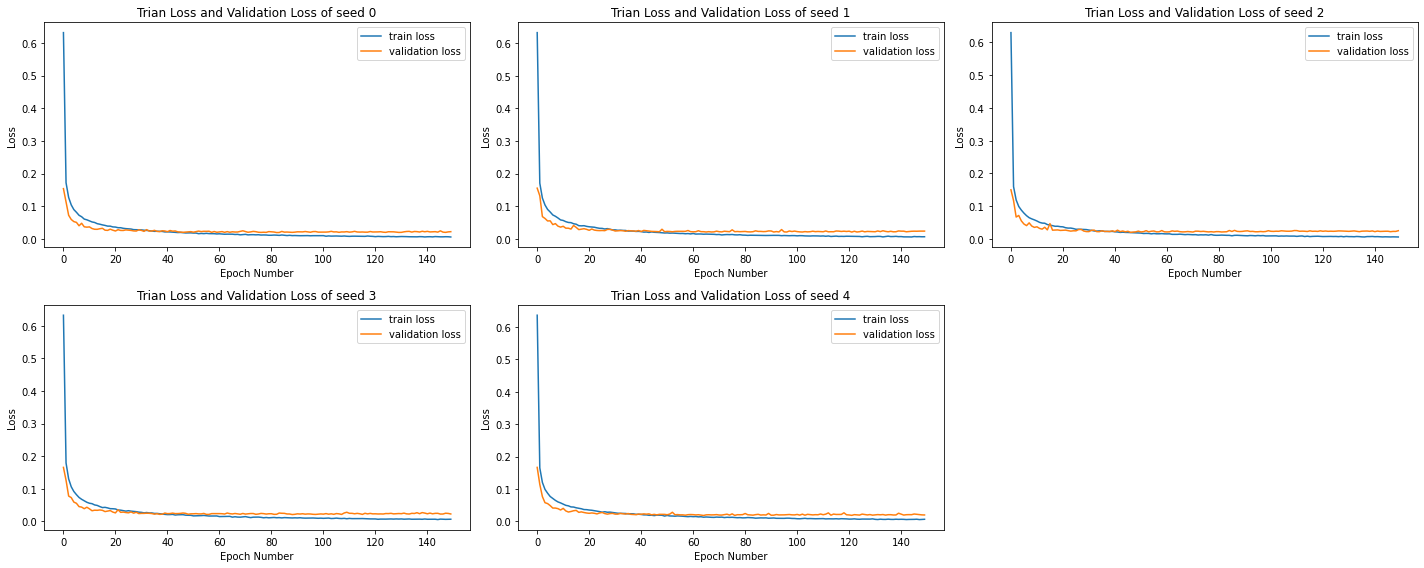

In [13]:
fig,ax = plt.subplots(2,3, figsize=(20,8))
for i in range(2):
  for j in range(3):
    if i==1 and j==2:
      break
    else:
      ax[i][j].plot(cnn2_results.loc[:, cnn2_results.columns.str.startswith("trloss_")].values[:,i*3+j], label="train loss")
      ax[i][j].plot(cnn2_results.loc[:, cnn2_results.columns.str.startswith("valloss_")].values[:,i*3+j], label="validation loss")
      ax[i][j].set_title("Trian Loss and Validation Loss of seed "+str(i*3+j))
      ax[i][j].set_xlabel("Epoch Number")
      ax[i][j].set_ylabel("Loss")
      ax[i][j].legend()
plt.tight_layout()
plt.delaxes(ax[1][2])
plt.legend()

## (b) Mislclassification Rate vs. Epoch

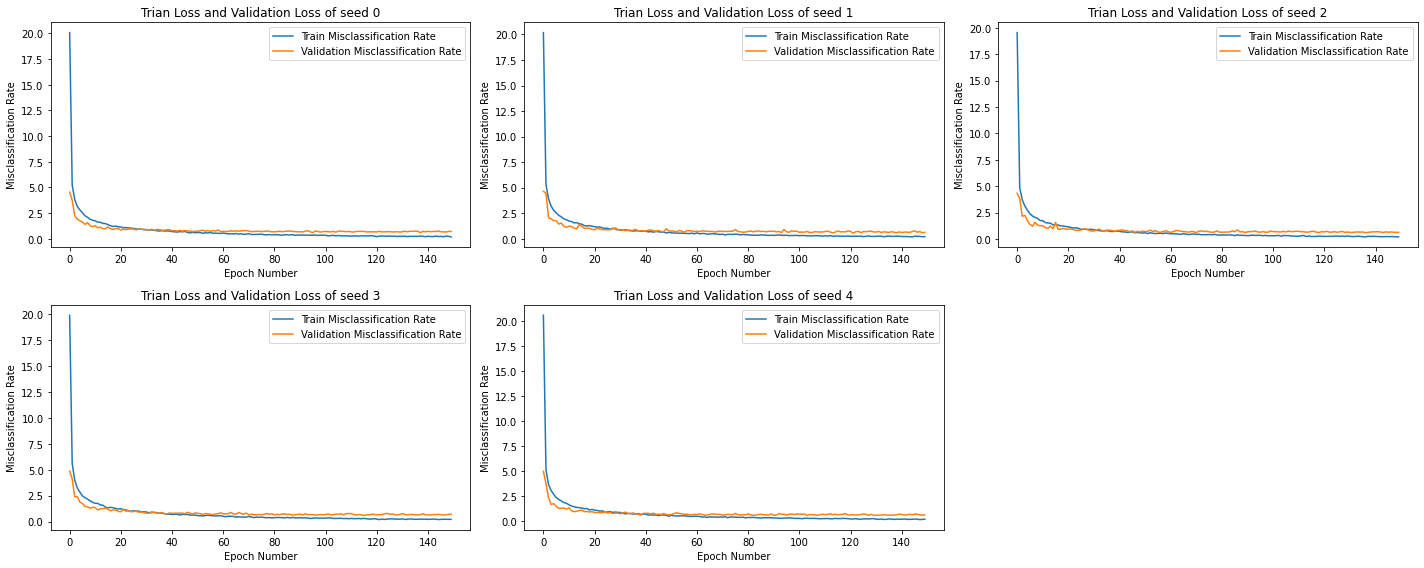

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(20,8))
for i in range(2):
  for j in range(3):
    if i==1 and j==2:
      break
    else:
      ax[i][j].plot(cnn2_results.loc[:, cnn2_results.columns.str.startswith("trerror_")].values[:,i*3+j]*100, label="Train Misclassification Rate")
      ax[i][j].plot(cnn2_results.loc[:, cnn2_results.columns.str.startswith("valerror_")].values[:,i*3+j]*100, label="Validation Misclassification Rate")
      ax[i][j].set_title("Trian Loss and Validation Loss of seed "+str(i*3+j))
      ax[i][j].set_xlabel("Epoch Number")
      ax[i][j].set_ylabel("Misclassification Rate")
      ax[i][j].legend()
plt.tight_layout()
plt.delaxes(ax[1][2])

## (c) Visualization of learned W

In [ ]:
cnn2_results.loc[:, cnn2_results.columns.str.startswith("valloss_")].sum(axis=0).sort_values()

valloss_time4    3.761124
valloss_time0    3.862688
valloss_time1    3.990394
valloss_time2    4.044215
valloss_time3    4.152207
dtype: float64

In [41]:
cnn2_best = cnn2(4)

In [42]:
score = cnn2_best[0].evaluate(x_test, y_test_encoding, verbose=0)
(1-score[1])*100

0.6399989128112793

In [43]:
cnn2_weights = cnn2_best[0].layers[0].get_weights()[0][:,:,0,:]

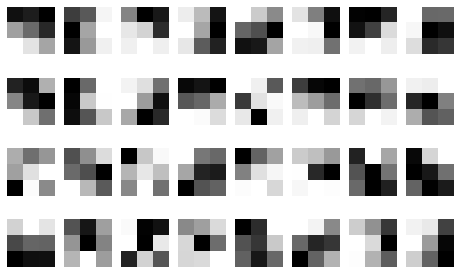

In [45]:
fig,ax=plt.subplots(4,8, figsize=(8,5))
for i in range(4):
  for j in range(8):
    ax[i,j].imshow(cnn2_weights[:,:,i*8+j],cmap="Greys")
    ax[i,j].axis("off")

## Different parameters

In [ ]:
#cnn2_lr_001 = cnn2(0, epoch=100, lr=0.01)
#cnn2_lr_02 = cnn2(0,epoch=100, lr=0.2)

#cnn2_mmt_05 = cnn2(0, epoch=100, mmt=0.5)
#cnn2_mmt_09 = cnn2(0, epoch=100, mmt=0.9)

In [ ]:
#cnn2_lr_mmt = pd.concat([cnn2_lr_001[1].add_prefix("lr001_"), cnn2_lr_02[1].add_prefix("lr02_"), cnn2_mmt_05[1].add_prefix("mmt05_"), cnn2_mmt_09[1].add_prefix("mmt09_")],axis=1)
#cnn2_final = pd.concat([cnn2_results, cnn2_lr_mmt],axis=1)
#cnn2_final.to_csv("cnn2_results1.csv")
#cnn2_results = pd.read_csv("drive/MyDrive/5241 Project/cnn2_results1.csv", index_col=0)
#cnn2_results

### Different Learning Rate

In [47]:
cnn2_results.loc[:, cnn2_results.columns.str.endswith("accuracy")] = (1-cnn2_results.loc[:, cnn2_results.columns.str.endswith("accuracy")])*100
cnn2_results.head(2)

,trloss_time0,trloss_time1,trloss_time2,trloss_time3,trloss_time4,valloss_time0,valloss_time1,valloss_time2,valloss_time3,valloss_time4,...,lr02_val_loss,lr02_val_accuracy,mmt05_loss,mmt05_accuracy,mmt05_val_loss,mmt05_val_accuracy,mmt09_loss,mmt09_accuracy,mmt09_val_loss,mmt09_val_accuracy
0,0.631442,0.632609,0.630025,0.632706,0.636034,0.153994,0.155220,0.15004,0.165643,0.166609,...,0.103827,3.149998,0.452604,14.408332,0.106584,3.219998,0.487999,15.191668,0.081855,2.689999
1,0.172016,0.170421,0.159864,0.179356,0.165043,0.113343,0.131807,0.11722,0.126212,0.114248,...,0.074302,2.530003,0.123420,3.811669,0.076543,2.660000,0.108924,3.399998,0.047765,1.650000


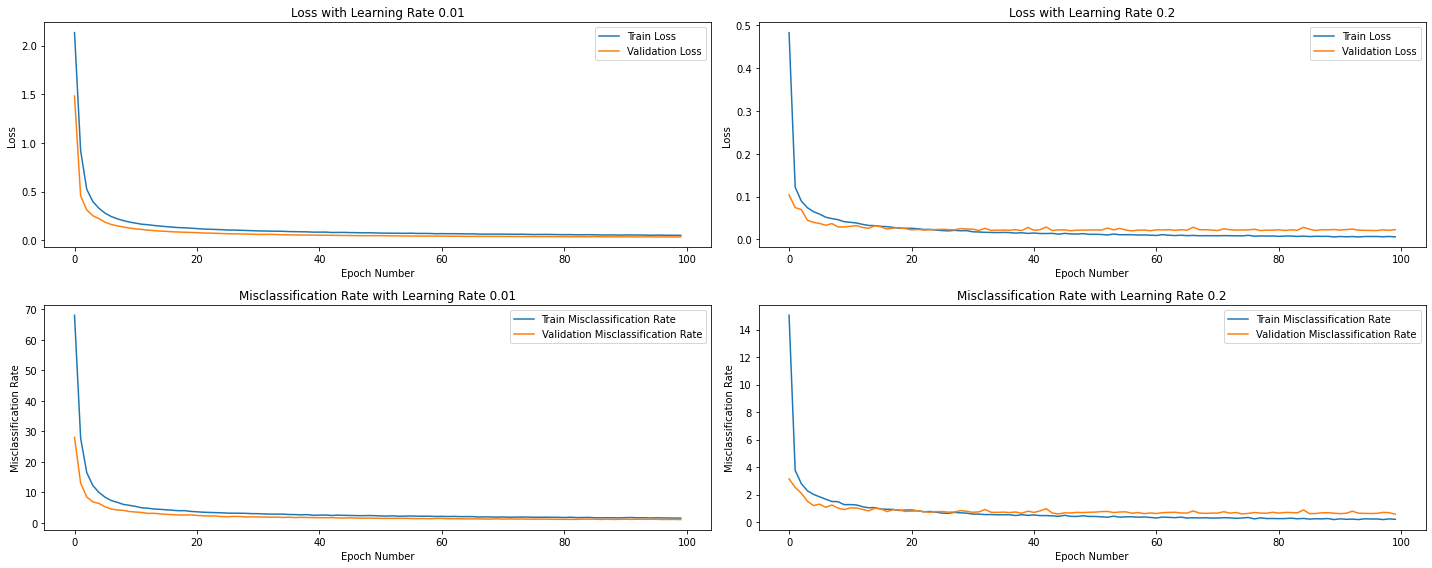

In [48]:
fig,ax = plt.subplots(2,2, figsize=(20,8))
pivots = ["001","02","05","09"]
rate = ["0.01","0.2","0.5","0.9"]
for i in range(2):
  for j in range(2):
    if j==0:
      kind="Loss"
    else:
      kind="Misclassification Rate"
    ax[j][i].plot(cnn2_results.loc[:, cnn2_results.columns.str.startswith("lr"+pivots[i])].iloc[:,j], label=str("Train "+kind))
    ax[j][i].plot(cnn2_results.loc[:, cnn2_results.columns.str.startswith("lr"+pivots[i])].iloc[:,j+2], label=str("Validation "+kind))
    ax[j][i].set_xlabel("Epoch Number")
    ax[j][i].set_ylabel(kind)
    ax[j][i].legend()
    ax[j][i].set_title(kind+" with "+"Learning Rate "+rate[i])
plt.tight_layout()
plt.legend()

### Different Momentum

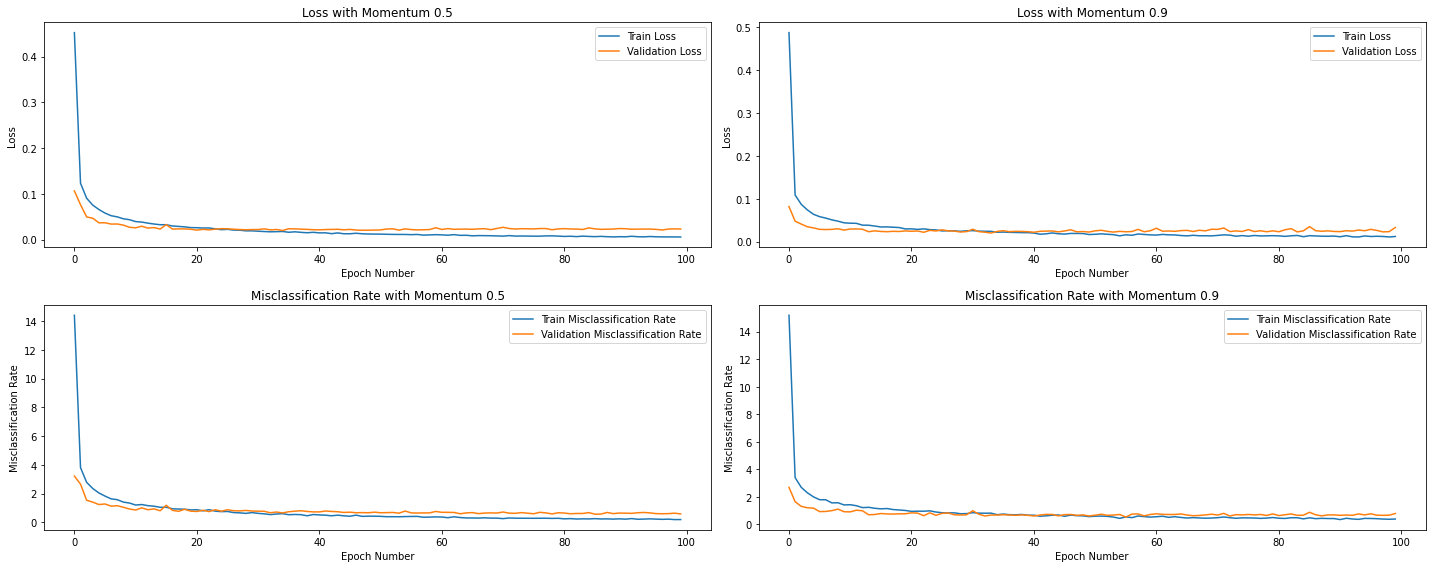

In [49]:
fig,ax = plt.subplots(2,2, figsize=(20,8))
pivots = ["001","02","05","09"]
rate = ["0.01","0.2","0.5","0.9"]
for i in range(2):
  for j in range(2):
    if j==0:
      kind="Loss"
    else:
      kind="Misclassification Rate"
    ax[j][i].plot(cnn2_results.loc[:, cnn2_results.columns.str.startswith("mmt"+pivots[i+2])].dropna().iloc[:,j], label=str("Train "+kind))
    ax[j][i].plot(cnn2_results.loc[:, cnn2_results.columns.str.startswith("mmt"+pivots[i+2])].dropna().iloc[:,j+2], label=str("Validation "+kind))
    ax[j][i].set_xlabel("Epoch Number")
    ax[j][i].set_ylabel(kind)
    ax[j][i].legend()
    ax[j][i].set_title(kind+" with "+"Momentum "+rate[i+2])
plt.tight_layout()
plt.legend()

# Problem 6

In [65]:
names = [str(i) for i in list(range(1,1570))]
names = ["X"+i for i in names]
x_train = pd.read_csv("data/train.txt", names=names)
y_train = x_train.X1569
x_train.drop(['X1569'],axis=1,inplace=True)
print(x_train.shape)
print(y_train.shape)

(20000, 1568)
(20000,)


In [66]:
names = [str(i) for i in list(range(1,1570))]
names = ["X"+i for i in names]
x_val = pd.read_csv("data/val.txt", names=names)
y_val = x_val.X1569
x_val.drop(['X1569'],axis=1,inplace=True)
print(x_val.shape)
print(y_val.shape)

(5000, 1568)
(5000,)


In [67]:
names = [str(i) for i in list(range(1,1570))]
names = ["X"+i for i in names]
x_test = pd.read_csv("data/test.txt", names=names)
y_test = x_test.X1569
x_test.drop(['X1569'],axis=1,inplace=True)
print(x_test.shape)
print(y_test.shape)

(5000, 1568)
(5000,)


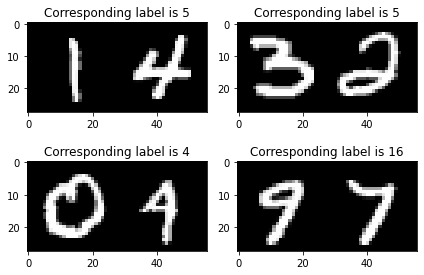

In [64]:
figure,ax=plt.subplots(2,2, figsize=(6,4))
for i in range(2):
  for j in range(2):
    ax[i][j].imshow(np.array(x_train.iloc[i*2+j,:]).reshape(28,28*2),cmap="gray")
    ax[i][j].set_title("Corresponding label is "+str(y_train[i*2+j]))
figure.tight_layout()

# Problem 7 - First Model

In [68]:
x_train = x_train.values.reshape(20000,28,28*2)
x_val = x_val.values.reshape(5000,28,28*2)
x_test = x_test.values.reshape(5000,28,28*2)

In [69]:
y_train_encoding = to_categorical(y_train)
y_val_encoding = to_categorical(y_val)
y_test_encoding = to_categorical(y_test)

In [ ]:
#plt.imshow(x_train[0])

In [70]:
def cnn3(x, epoch=150, batch=256, lr=0.1, mmt=0):
  tf.random.set_seed(x)
  cnn = keras.models.Sequential([Conv2D(6, (5, 5), padding="same", activation = "tanh", input_shape = (28, 28*2, 1)),
                                 MaxPooling2D(2, 2),
                                 Conv2D(16, (5, 5), padding="same", activation = "tanh"),
                                 MaxPooling2D(2, 2),
                                 Conv2D(120, (5, 5), padding="same", activation = "tanh"),
                                 Dropout(0.2),
                                 Flatten(),
                                 Dense(85, activation="tanh"),
                                 Dense(19,activation="softmax")])
  cnn.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=lr,momentum=mmt),
             metrics=['accuracy'])
  history = cnn.fit(x_train, y_train_encoding, epochs=epoch, batch_size=batch, validation_data=(x_val, y_val_encoding),verbose=0)
  
  df = pd.DataFrame(history.history)

  return cnn,df

In [ ]:
cnn3_trloss=pd.DataFrame()
cnn3_valloss=pd.DataFrame()
cnn3_trerror=pd.DataFrame()
cnn3_valerror=pd.DataFrame()

for i in range(5):
  temp = cnn3(i)[1]
  cnn3_trloss["time"+str(i)] = temp.loss
  cnn3_valloss["time"+str(i)] = temp.val_loss
  cnn3_trerror["time"+str(i)] = 1-temp.accuracy.values
  cnn3_valerror["time"+str(i)] = 1-temp.val_accuracy.values

In [ ]:
cnn3_results = pd.concat([cnn3_trloss.add_prefix("trloss_"),cnn3_valloss.add_prefix("valloss_"),
           cnn3_trerror.add_prefix("trerror_"),
           cnn3_valerror.add_prefix("valerror_")],axis=1)
#cnn3_results.to_csv("cnn3_results.csv")
cnn3_results = pd.read_csv("output/cnn3_results1.csv", index_col=0)

## (a) Cross-entropy Rate vs. Epoch

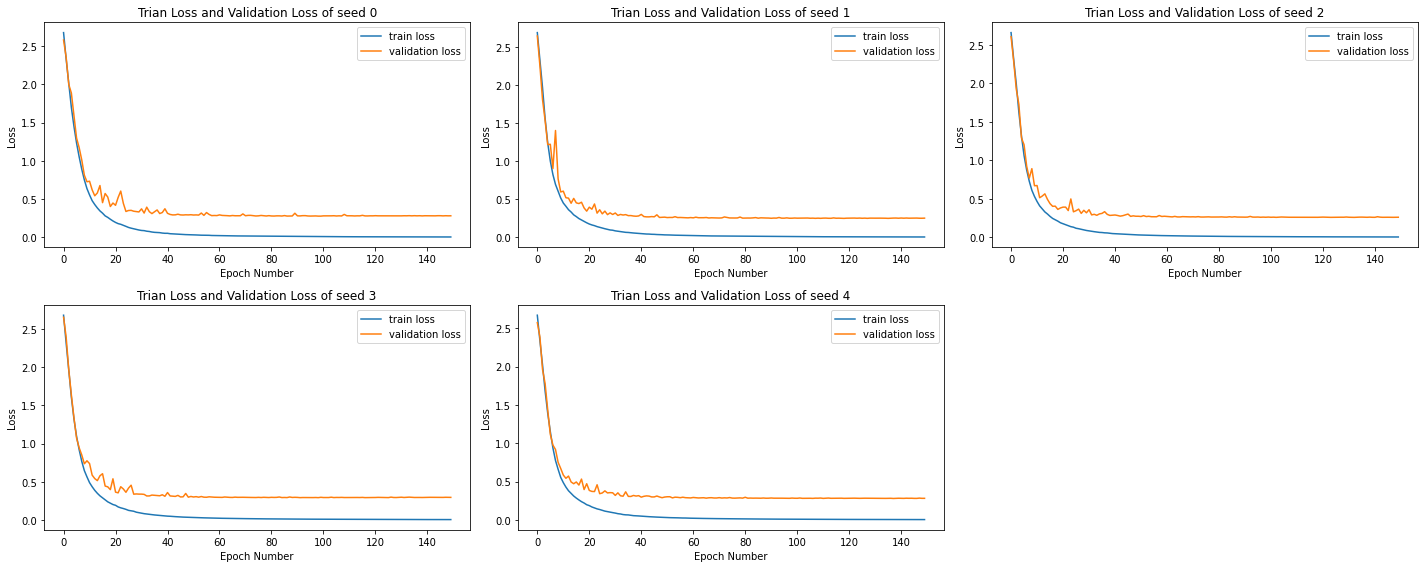

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(20,8))
for i in range(2):
  for j in range(3):
    if i==1 and j==2:
      break
    else:
      ax[i][j].plot(cnn3_results.loc[:, cnn3_results.columns.str.startswith("trloss_")].values[:,i*3+j], label="train loss")
      ax[i][j].plot(cnn3_results.loc[:, cnn3_results.columns.str.startswith("valloss_")].values[:,i*3+j], label="validation loss")
      ax[i][j].set_title("Trian Loss and Validation Loss of seed "+str(i*3+j))
      ax[i][j].set_xlabel("Epoch Number")
      ax[i][j].set_ylabel("Loss")
      ax[i][j].legend()
plt.tight_layout()
plt.delaxes(ax[1][2])
plt.legend()

## (b) Misclassification Rate vs. Epoch

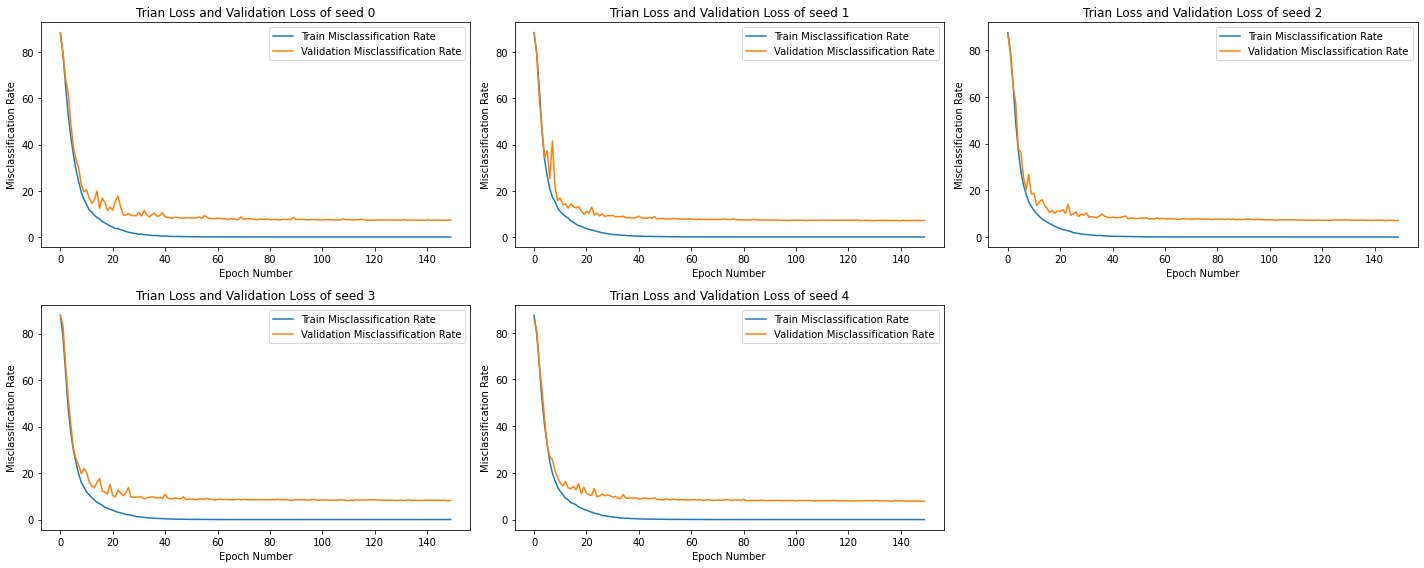

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(20,8))
for i in range(2):
  for j in range(3):
    if i==1 and j==2:
      break
    else:
      ax[i][j].plot(cnn3_results.loc[:, cnn3_results.columns.str.startswith("trerror_")].values[:,i*3+j]*100, label="Train Misclassification Rate")
      ax[i][j].plot(cnn3_results.loc[:, cnn3_results.columns.str.startswith("valerror_")].values[:,i*3+j]*100, label="Validation Misclassification Rate")
      ax[i][j].set_title("Trian Loss and Validation Loss of seed "+str(i*3+j))
      ax[i][j].set_xlabel("Epoch Number")
      ax[i][j].set_ylabel("Misclassification Rate")
      ax[i][j].legend()
plt.tight_layout()
plt.delaxes(ax[1][2])

## (c) Visualization of Learned W

In [ ]:
cnn3_results.loc[:, cnn3_results.columns.str.startswith("valloss_")].sum(axis=0).sort_values()

valloss_time1    53.658441
valloss_time2    55.142721
valloss_time4    58.225163
valloss_time3    59.630812
valloss_time0    59.910496
dtype: float64

In [71]:
cnn3_best = cnn3(1)

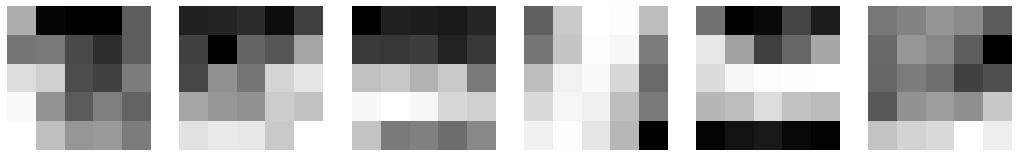

In [72]:
cnn3_weights = cnn3_best[0].layers[0].get_weights()[0][:,:,0,:]
fig,ax=plt.subplots(1,6, figsize=(18,10))
for i in range(1):
  for j in range(6):
    ax[j].imshow(cnn3_weights[:,:,i*8+j],cmap="Greys")
    ax[j].axis("off")

In [ ]:
score = cnn3_best[0].evaluate(x_test, y_test_encoding, verbose=0)
(1-score[1])*100

6.480002403259277

## (d) Different Parameters

In [ ]:
cnn3_lr_001 = cnn3(0, epoch=150, lr=0.01)
cnn3_lr_02 = cnn3(0,epoch=150, lr=0.2)

cnn3_mmt_05 = cnn3(0, epoch=150, mmt=0.5)
cnn3_mmt_09 = cnn3(0, epoch=150, mmt=0.9)
#cnn3(0,epoch=100,lr=0.01)

In [73]:
#cnn3_lr_mmt = pd.concat([cnn3_lr_001[1].add_prefix("lr001_"), cnn3_lr_02[1].add_prefix("lr02_"), cnn3_mmt_05[1].add_prefix("mmt05_"), cnn3_mmt_09[1].add_prefix("mmt09_")],axis=1)
#cnn3_final = pd.concat([cnn3_results, cnn3_lr_mmt],axis=1)
#cnn3_final.to_csv("cnn3_results1.csv")
cnn3_results = pd.read_csv("output/cnn3_results1.csv", index_col=0)
#cnn3_final
#cnn3_results

### Different Learning Rate

In [74]:
cnn3_results.loc[:, cnn3_results.columns.str.endswith("accuracy")] = (1-cnn3_results.loc[:, cnn3_results.columns.str.endswith("accuracy")])*100
cnn3_results.head(2)

,trloss_time0,trloss_time1,trloss_time2,trloss_time3,trloss_time4,valloss_time0,valloss_time1,valloss_time2,valloss_time3,valloss_time4,...,lr02_val_loss,lr02_val_accuracy,mmt05_loss,mmt05_accuracy,mmt05_val_loss,mmt05_val_accuracy,mmt09_loss,mmt09_accuracy,mmt09_val_loss,mmt09_val_accuracy
0,2.673532,2.685980,2.659087,2.678713,2.669864,2.576918,2.641642,2.606572,2.652126,2.572967,...,2.508791,85.640000,2.546899,85.405,2.44562,82.82,2.256346,75.080000,2.077708,68.059999
1,2.327097,2.329398,2.314276,2.313608,2.336890,2.350732,2.250405,2.288456,2.391383,2.385896,...,2.030468,66.800001,1.974836,64.420,1.78546,57.42,1.172024,36.154997,0.865589,25.620002


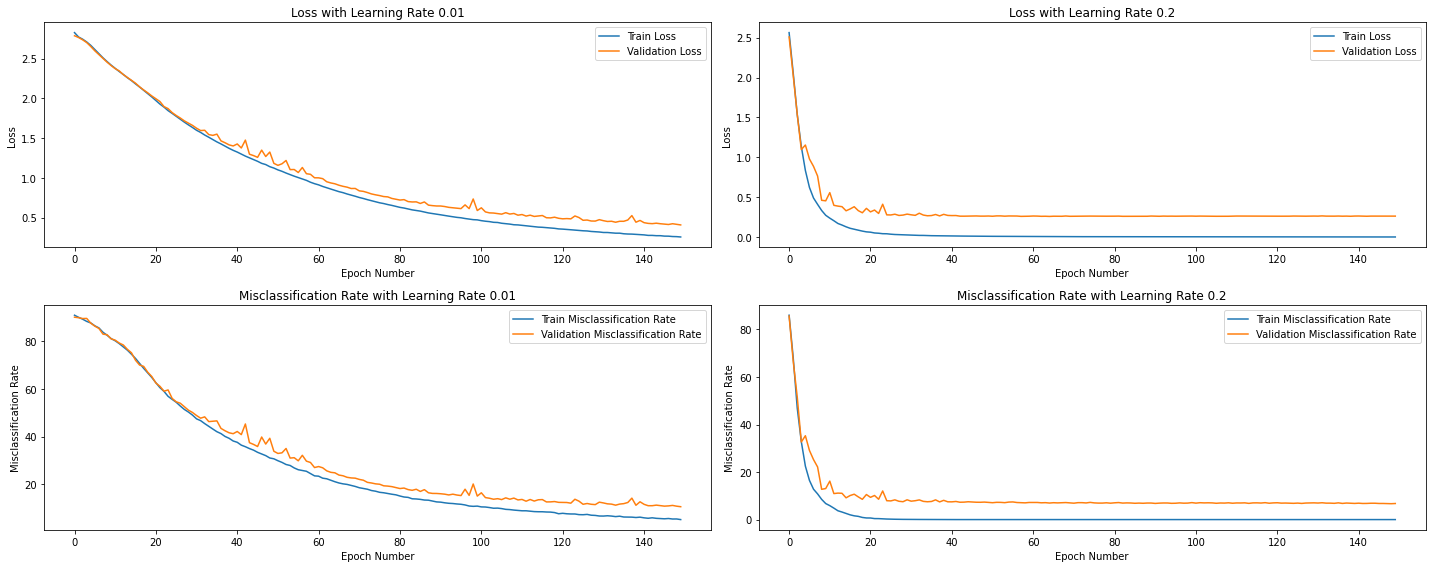

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(20,8))
pivots = ["001","02","05","09"]
rate = ["0.01","0.2","0.5","0.9"]
for i in range(2):
  for j in range(2):
    if j==0:
      kind="Loss"
    else:
      kind="Misclassification Rate"
    ax[j][i].plot(cnn3_results.loc[:, cnn3_results.columns.str.startswith("lr"+pivots[i])].iloc[:,j], label=str("Train "+kind))
    ax[j][i].plot(cnn3_results.loc[:, cnn3_results.columns.str.startswith("lr"+pivots[i])].iloc[:,j+2], label=str("Validation "+kind))
    ax[j][i].set_xlabel("Epoch Number")
    ax[j][i].set_ylabel(kind)
    ax[j][i].legend()
    ax[j][i].set_title(kind+" with "+"Learning Rate "+rate[i])
plt.tight_layout()
plt.legend()

### Different Momentun

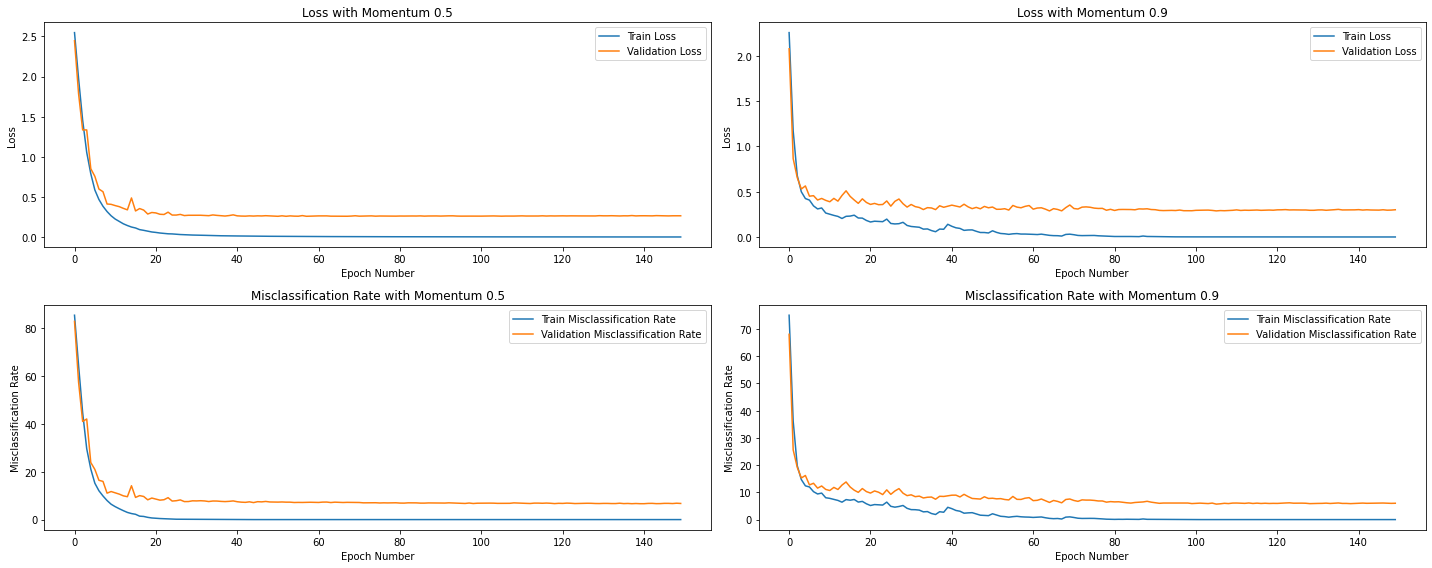

In [75]:
fig,ax = plt.subplots(2,2, figsize=(20,8))
pivots = ["001","02","05","09"]
rate = ["0.01","0.2","0.5","0.9"]
for i in range(2):
  for j in range(2):
    if j==0:
      kind="Loss"
    else:
      kind="Misclassification Rate"
    ax[j][i].plot(cnn3_results.loc[:, cnn3_results.columns.str.startswith("mmt"+pivots[i+2])].dropna().iloc[:,j], label=str("Train "+kind))
    ax[j][i].plot(cnn3_results.loc[:, cnn3_results.columns.str.startswith("mmt"+pivots[i+2])].dropna().iloc[:,j+2], label=str("Validation "+kind))
    ax[j][i].set_xlabel("Epoch Number")
    ax[j][i].set_ylabel(kind)
    ax[j][i].legend()
    ax[j][i].set_title(kind+" with "+"Momentum "+rate[i+2])
plt.tight_layout()
plt.legend()

# Problem 7 - Second Model

In [78]:
def cnn4(x, epoch=150, batch=256, lr=0.1, mmt=0):
  tf.random.set_seed(x)
  cnn = keras.models.Sequential([Conv2D(32, (5, 5), padding="same", activation = "tanh", input_shape = (28, 28*2, 1)),
                                Conv2D(32, (5, 5), padding="same", activation = "tanh"),
                                Conv2D(32, (5, 5), padding="same", strides=2, activation = "tanh"),
                                Conv2D(32, (5, 5), activation = "tanh"),
                                Conv2D(32, (5, 5), padding="same", activation = "tanh"),
                                Conv2D(32, (5, 5), padding="same", strides=2, activation = "tanh"),
                                Flatten(),
                                Dense(256, activation="tanh"),
                                Dense(19,activation="softmax")])
  cnn.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=lr,momentum=mmt),
             metrics=['accuracy'])
  history = cnn.fit(x_train, y_train_encoding, epochs=epoch, batch_size=batch, validation_data=(x_val, y_val_encoding),verbose=1)
  
  df = pd.DataFrame(history.history)

  return cnn,df

In [ ]:
cnn4_trloss=pd.DataFrame()
cnn4_valloss=pd.DataFrame()
cnn4_trerror=pd.DataFrame()
cnn4_valerror=pd.DataFrame()

for i in range(5):
  temp = cnn4(i)[1]
  cnn4_trloss["time"+str(i)] = temp.loss
  cnn4_valloss["time"+str(i)] = temp.val_loss
  cnn4_trerror["time"+str(i)] = 1-temp.accuracy.values
  cnn4_valerror["time"+str(i)] = 1-temp.val_accuracy.values

In [6]:
#cnn4_results = pd.concat([cnn4_trloss.add_prefix("trloss_"),cnn4_valloss.add_prefix("valloss_"),
#           cnn4_trerror.add_prefix("trerror_"),
#           cnn4_valerror.add_prefix("valerror_")],axis=1)
#cnn4_results.to_csv("cnn4_results.csv")
cnn4_results = pd.read_csv("output/cnn4_results1.csv", index_col=0)

## (a) Cross-entropy Rate vs. Epoch

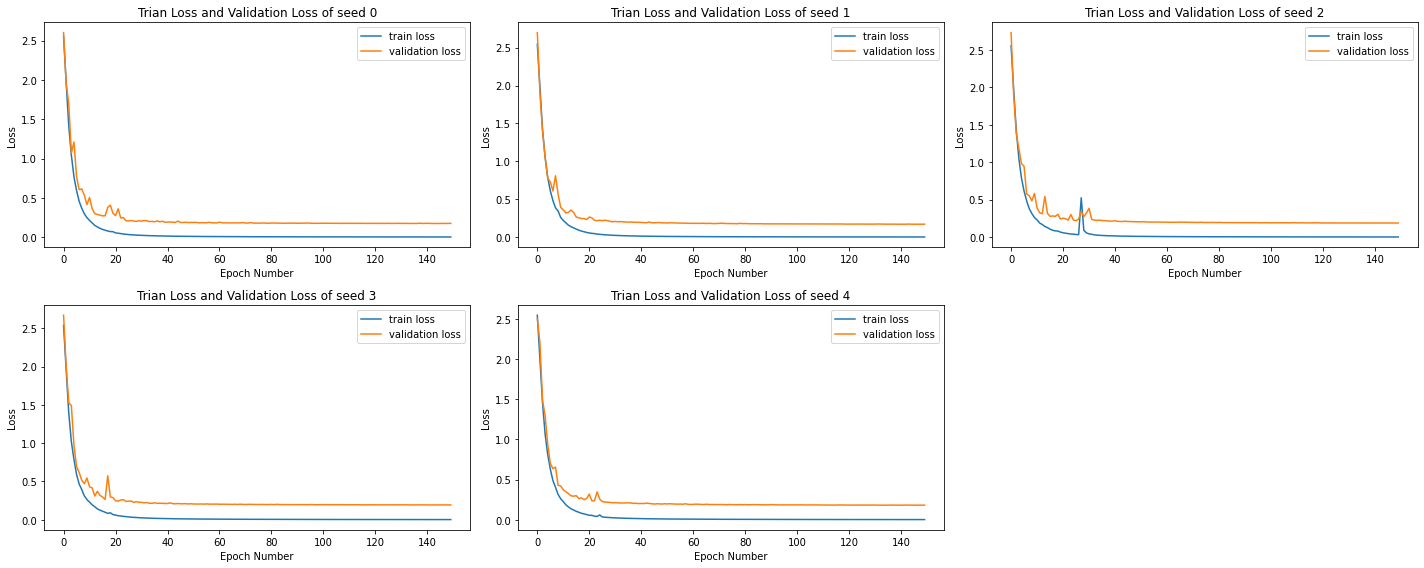

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(20,8))
for i in range(2):
  for j in range(3):
    if i==1 and j==2:
      break
    else:
      ax[i][j].plot(cnn4_results.loc[:, cnn4_results.columns.str.startswith("trloss_")].values[:,i*3+j], label="train loss")
      ax[i][j].plot(cnn4_results.loc[:, cnn4_results.columns.str.startswith("valloss_")].values[:,i*3+j], label="validation loss")
      ax[i][j].set_title("Trian Loss and Validation Loss of seed "+str(i*3+j))
      ax[i][j].set_xlabel("Epoch Number")
      ax[i][j].set_ylabel("Loss")
      ax[i][j].legend()
plt.tight_layout()
plt.delaxes(ax[1][2])
plt.legend()

## (b) Misclassification Rate vs. Epoch

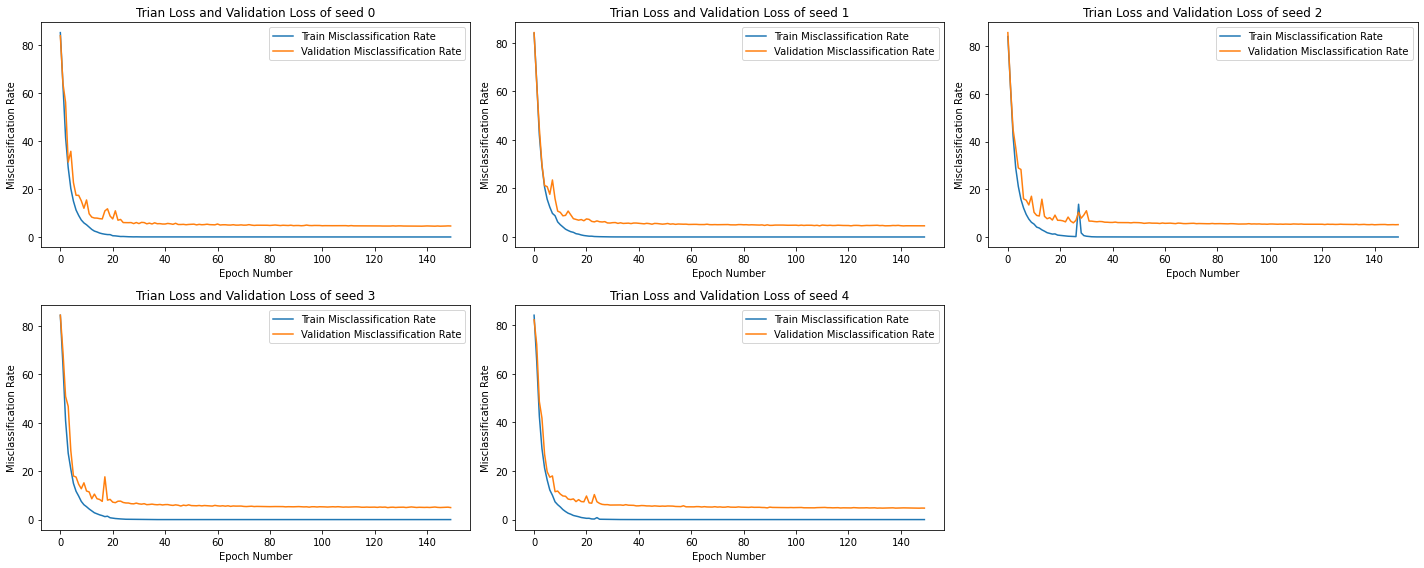

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(20,8))
for i in range(2):
  for j in range(3):
    if i==1 and j==2:
      break
    else:
      ax[i][j].plot(cnn4_results.loc[:, cnn4_results.columns.str.startswith("trerror_")].values[:,i*3+j]*100, label="Train Misclassification Rate")
      ax[i][j].plot(cnn4_results.loc[:, cnn4_results.columns.str.startswith("valerror_")].values[:,i*3+j]*100, label="Validation Misclassification Rate")
      ax[i][j].set_title("Trian Loss and Validation Loss of seed "+str(i*3+j))
      ax[i][j].set_xlabel("Epoch Number")
      ax[i][j].set_ylabel("Misclassification Rate")
      ax[i][j].legend()
plt.tight_layout()
plt.delaxes(ax[1][2])

## (c) Visualization of Learned W

In [ ]:
cnn4_results.loc[:, cnn4_results.columns.str.startswith("valloss_")].sum(axis=0).sort_values()

valloss_time1    37.615093
valloss_time0    38.892227
valloss_time4    39.409327
valloss_time2    41.068630
valloss_time3    41.556548
dtype: float64

In [ ]:
cnn4_best = cnn4(1)

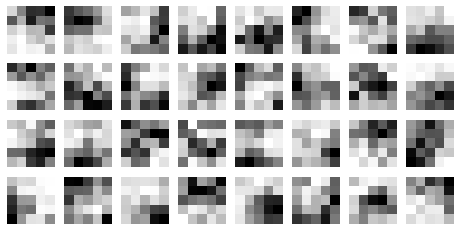

In [81]:
cnn4_weights = cnn4_best[0].layers[0].get_weights()[0][:,:,0,:]
fig,ax=plt.subplots(4,8, figsize=(8,4))
for i in range(4):
  for j in range(8):
    ax[i,j].imshow(cnn4_weights[:,:,i*8+j],cmap="Greys")
    ax[i,j].axis('off')

## (d) Different Parameters

In [ ]:
#cnn4_lr_001 = cnn4(0, epoch=150, lr=0.01)
#cnn4_lr_02 = cnn4(0,epoch=150, lr=0.01)

#cnn4_mmt_05 = cnn4(0, epoch=150, mmt=0.5)
#cnn4_mmt_09 = cnn4(0, epoch=150, mmt=0.9)

In [9]:
#cnn4_lr_mmt = pd.concat([cnn4_lr_001[1].add_prefix("lr001_"), cnn4_lr_02[1].add_prefix("lr02_"), cnn4_mmt_05[1].add_prefix("mmt05_"), cnn4_mmt_09[1].add_prefix("mmt09_")],axis=1)
#cnn4_final = pd.concat([cnn4_results, cnn4_lr_mmt],axis=1)
#cnn4_final.to_csv("cnn4_results1.csv")
#cnn4_results = pd.read_csv("drive/MyDrive/5241 Project/cnn4_results1.csv", index_col=0)

### Different Learning Rate

In [10]:
cnn4_results.loc[:, cnn4_results.columns.str.endswith("accuracy")] = (1-cnn4_results.loc[:, cnn4_results.columns.str.endswith("accuracy")])*100

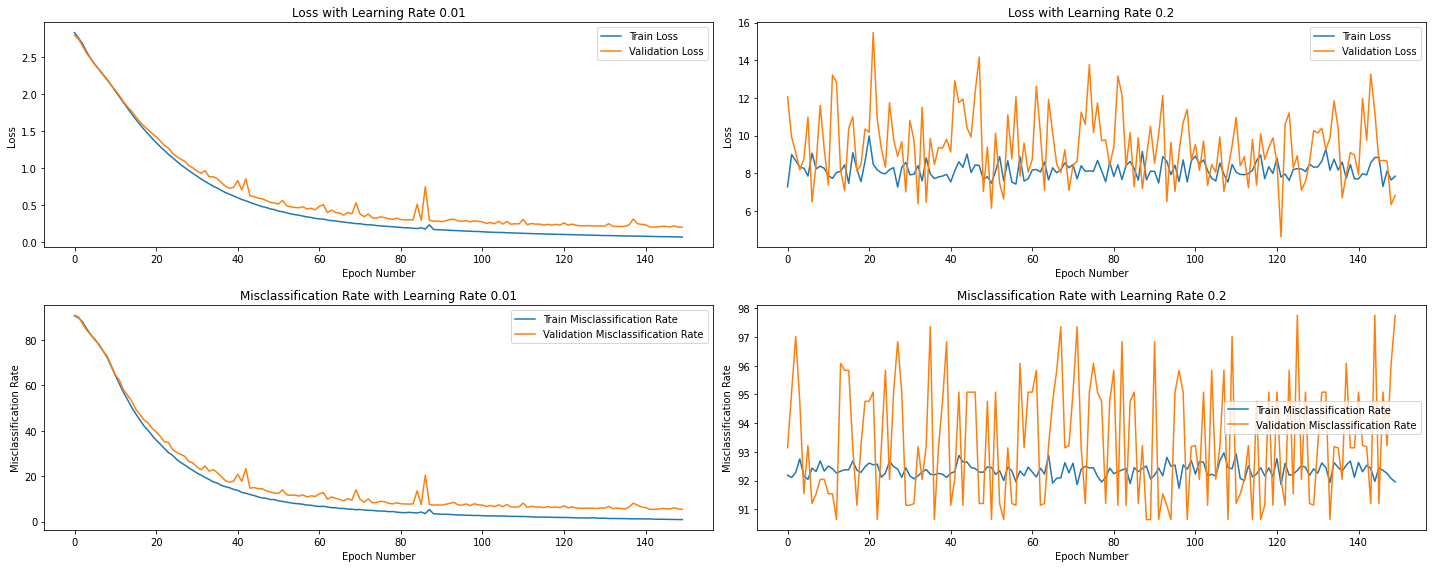

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(20,8))
pivots = ["001","02","05","09"]
rate = ["0.01","0.2","0.5","0.9"]
for i in range(2):
  for j in range(2):
    if j==0:
      kind="Loss"
    else:
      kind="Misclassification Rate"
    ax[j][i].plot(cnn4_results.loc[:, cnn4_results.columns.str.startswith("lr"+pivots[i])].iloc[:,j], label=str("Train "+kind))
    ax[j][i].plot(cnn4_results.loc[:, cnn4_results.columns.str.startswith("lr"+pivots[i])].iloc[:,j+2], label=str("Validation "+kind))
    ax[j][i].set_xlabel("Epoch Number")
    ax[j][i].set_ylabel(kind)
    ax[j][i].legend()
    ax[j][i].set_title(kind+" with "+"Learning Rate "+rate[i])
plt.tight_layout()
plt.legend()

### Different Momentum

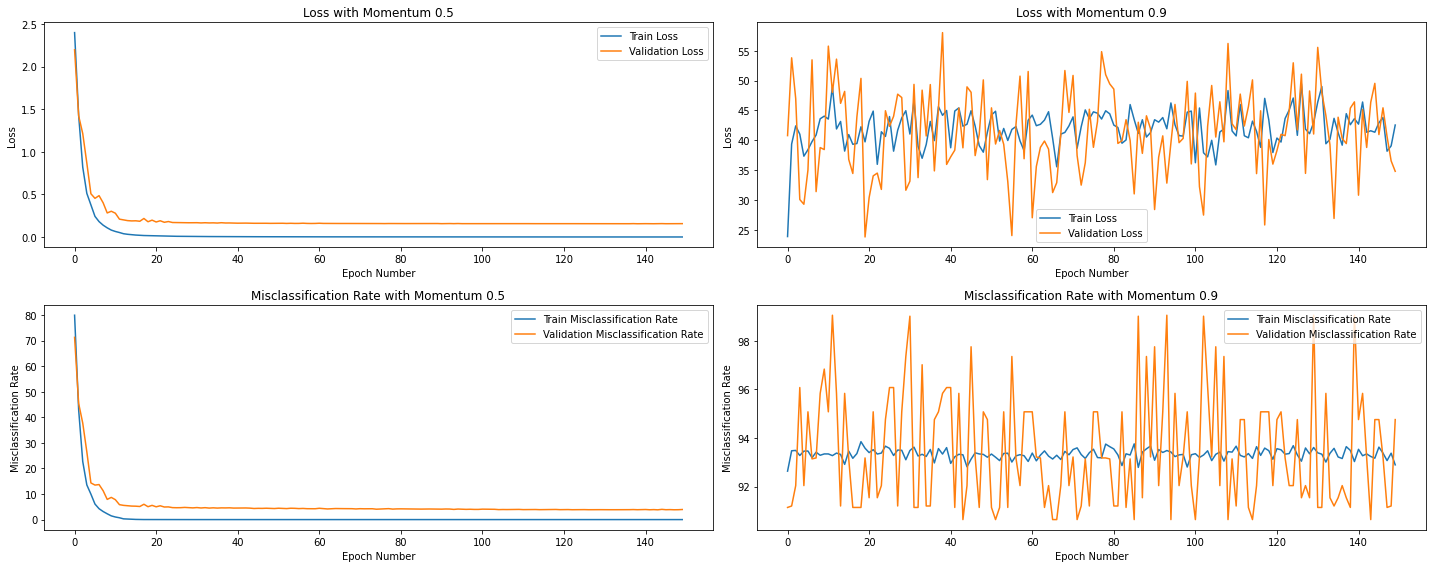

In [11]:
fig,ax = plt.subplots(2,2, figsize=(20,8))
pivots = ["001","02","05","09"]
rate = ["0.01","0.2","0.5","0.9"]
for i in range(2):
  for j in range(2):
    if j==0:
      kind="Loss"
    else:
      kind="Misclassification Rate"
    ax[j][i].plot(cnn4_results.loc[:, cnn4_results.columns.str.startswith("mmt"+pivots[i+2])].dropna().iloc[:,j], label=str("Train "+kind))
    ax[j][i].plot(cnn4_results.loc[:, cnn4_results.columns.str.startswith("mmt"+pivots[i+2])].dropna().iloc[:,j+2], label=str("Validation "+kind))
    ax[j][i].set_xlabel("Epoch Number")
    ax[j][i].set_ylabel(kind)
    ax[j][i].legend()
    ax[j][i].set_title(kind+" with "+"Momentum "+rate[i+2])
plt.tight_layout()
plt.legend()

In [ ]:
score = cnn4_best[0].evaluate(x_test, y_test_encoding, verbose=0)
score[1]*100

95.99999785423279